# Gesture Recognition Project
#### By: Siddhant Pattanaik

## **Problem statement:**

Build a model which can recognise five different gestures to control a smart TV.
The five gestures are below:

| **Gesture**     | **Action**                  |
| :- | :- |
| **Thumbs up**   | Increase the volume         |
| **Thumbs down** | Decrease the volume         |
| **Left Swipe**  | 'Jump' backward 10 seconds  |
| **Right Swipe** | 'Jump' forward 10 seconds   |
| **Stop**        | Pause the movie             |

## Initial Setup 

In [1]:
# Importing some libraries to work with paths
import pathlib
import glob
import os

# Define Jarvis base directory - Toggle off if using Colab
base_dir = pathlib.Path('/home/datasets/')

# Define Google Colab base directory - Toggle off if using Jarvis
#base_dir = pathlib.Path('/content/gdrive/My Drive/Colab Notebooks/Gesture_Recognition_Case_Study/')

In [2]:
# Training and validation data are stored inside "Project_data" folder in the base directory
os.chdir(base_dir)
print(os.listdir('Project_data'))

['train', 'val', 'train.csv', 'val.csv']


In [3]:
# Importing required libraries
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K

from imageio import imread
from skimage.transform import resize
import scipy
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

import random as rn
import datetime
import os

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, TimeDistributed, BatchNormalization, Activation
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D, LSTM, GRU, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import optimizers,layers

In [4]:
print(tf.__version__)

2.3.1


We set the random seed so that the results don't vary drastically.

In [5]:
# Set seed values
np.random.seed(30)
rn.seed(30)
tf.random.set_seed(30)

In [6]:
# Read the lists of available train and validation directories with their classes. 
# Apply random permutation to shuffle them around, so that the same gestures are not bunched together.
train_doc = np.random.permutation(open('./Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('./Project_data/val.csv').readlines())

In [7]:
print("Number of training videos/sequences: ", len(train_doc))
print("Number of validation videos/sequences: ", len(val_doc))

Number of training videos/sequences:  663
Number of validation videos/sequences:  100


## Basic EDA of the dataset

Gesture label:  Right_Swipe_new


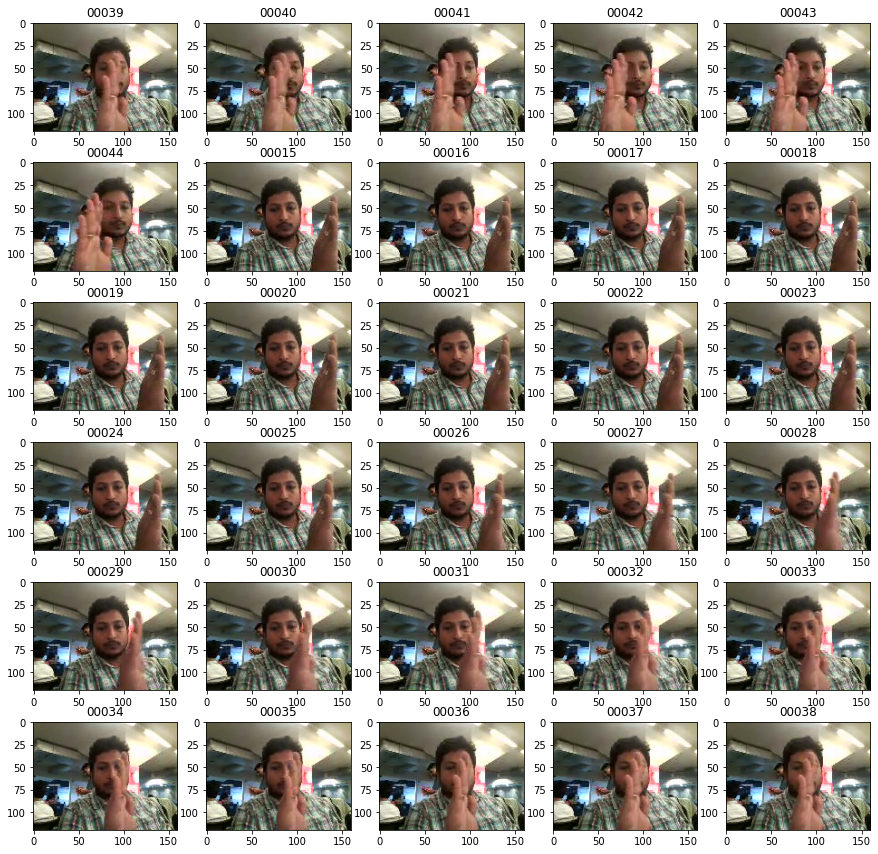

In [24]:
# Obtaining a sample video / sequence for display purposes
rand_idx = np.random.randint(0,len(train_doc))
sample_path = os.path.join(base_dir,'Project_data/train', train_doc[rand_idx].split(';')[0], '*')
sample_path = glob.glob(sample_path)

print("Gesture label: ", train_doc[rand_idx].split(';')[-2])

# Visualizing all the frames of the random sequence
plt.figure(figsize=(15,15))
for i in range(30):
  plt.subplot(6,5,i+1)
  
  # Read 'i'th image from the random folder
  image = imread(sample_path[i])
    
  # Obtain the frame no. within sequence from the file name
  frame_no = os.path.splitext(os.path.basename(sample_path[i]))[0].split('_')[-1]
  plt.title(frame_no)
  plt.imshow(image)
plt.show()

- **We can see above that the frames are not read sequentially from the beginning.**
- From the abrupt change in the gesture in the 2nd row above as well as the file numbers on top of each image, it can be concluded that the last 6 frames of each sequence are being read in first, followed by the rest of the video in sequence.
- **Hence, the frames need to be sorted using their filenames prior to input of a video in our generator function.**

Gesture label:  Right_Swipe_new


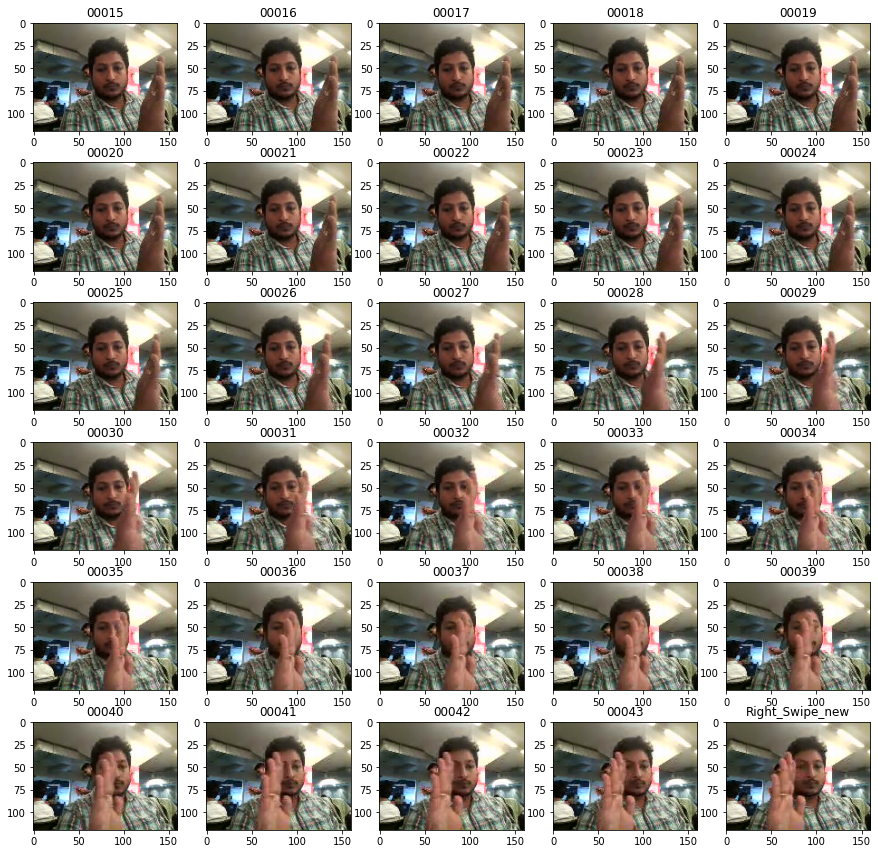

In [25]:
# Displaying the same video as above, but sorted sequentially this time.

# Sorting the file paths by file-name to follow the actual sequence of frames
sample_path = sorted(sample_path, key=lambda x: os.path.splitext(os.path.basename(x))[0])

print("Gesture label: ", train_doc[rand_idx].split(';')[-2])

# Visualizing the first 25 frames of a random sequence
plt.figure(figsize=(15,15))
for i in range(30):
  plt.subplot(6,5,i+1)
  image = imread(sample_path[i])
  frame_no = os.path.splitext(os.path.basename(sample_path[i]))[0].split('_')[-1]
  plt.title(frame_no)
  plt.imshow(image)
plt.title(train_doc[rand_idx].split(';')[-2])
plt.show()

#### It is important that the data being fed into the network is sorted sequentially, since that is the very essence of the training of a sequential model. This needs to be incorporated in the generator function defined later in the notebook.

In [26]:
print("Random index of above image for future use:", rand_idx)

Random index of above image for future use: 504


### Possible shapes of images in the training / validation data

In [ ]:
# Checking the different dimensions of images pressent in training set
dim_list = []
for i in range(len(train_doc)):
  path = os.path.join(base_dir,'Project_data/train', train_doc[i].split(';')[0], '*')
  path = glob.glob(path)
  temp_list=[]
  image = imread(path[0])
  dim_list.append(image.shape)
dim_set = set(dim_list)
print("Possible dimensions of images in training set: {}".format(dim_set))

Possible dimensions of images in training set: {(360, 360, 3), (120, 160, 3)}


In [ ]:
print(len(dim_list))

663


In [ ]:
# Checking the different dimensions of images pressent in validation set
dim_list_val = []
for i in range(len(val_doc)):
  path_val = os.path.join(base_dir,'Project_data/val', val_doc[i].split(';')[0], '*')
  path_val = glob.glob(path_val)
  image = imread(path_val[0])
  dim_list_val.append(image.shape)
dim_set_val = set(dim_list_val)
print("Possible dimensions of images in validation set: {}".format(dim_set_val))

Possible dimensions of images in validation set: {(360, 360, 3), (120, 160, 3)}


We see that there are 2 possible dimensions for all the videos:
- (120, 160, 3)
- (360, 360, 3)

We will need to account for this and resize one / both of the dimensions to bring them on the same footing for Convolutional layers to work properly.
Let's look at the effect of resizing and cropping on example images from both the available dimensions.

### Resizing / Cropping images with shape (120,160,3) to (120,120,3)


Original Image: (120,160,3)


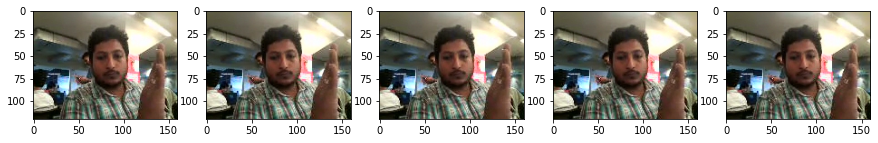


Resized Image: (120,160,3) to (120,120,3) - No cropping


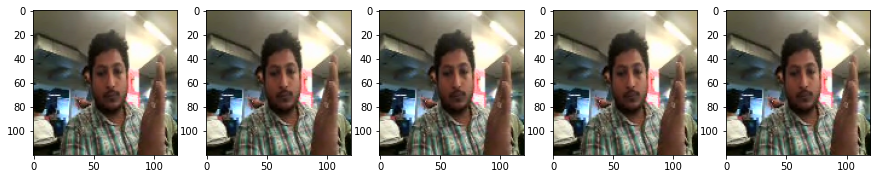


Cropped Image: (120,120,3)


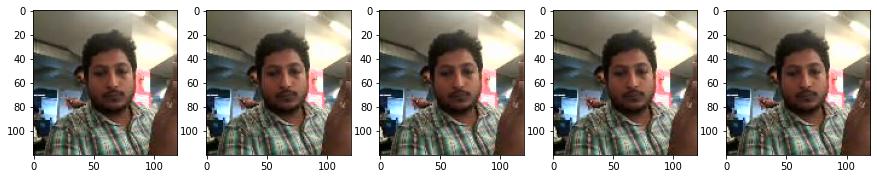

In [31]:
# Resizing / cropping images with shape (120,160,3) to a square shape of (120,120,3)

# Obtain path - Using the same random sequence we saw earlier.
sample_path1 = os.path.join(base_dir,'Project_data/train', train_doc[504].split(';')[0], '*')
sample_path1 = glob.glob(sample_path1)
sample_path1 = sorted(sample_path1, key=lambda x: os.path.splitext(os.path.basename(x))[0])

# Visualizing the first 5 frames of the sequence as it is
print("\nOriginal Image: (120,160,3)")
plt.figure(figsize=(15,10))
for i in range(5):
  plt.subplot(1,5,i+1)
  image = imread(sample_path1[i])
  plt.imshow(image)
plt.show()

# Visualizing the first 5 frames of the sequence after resizing to (120,120,3) - No cropping
print("\nResized Image: (120,160,3) to (120,120,3) - No cropping")
plt.figure(figsize=(15,10))
for i in range(5):
  plt.subplot(1,5,i+1)
  image = imread(sample_path1[i])
  image = resize(image, (120,120,3))
  plt.imshow(image)
plt.show()

# Visualizing the first 5 frames of the sequence after cropping to (120,120,3) - 20 pixels from each side removed
print("\nCropped Image: (120,120,3)")
plt.figure(figsize=(15,10))
for i in range(5):
  plt.subplot(1,5,i+1)
  image = imread(sample_path1[i])
  image = image[:,20:140,:]
  plt.imshow(image)
plt.show()

- We can see that resizing the images from (120,160,3) to a square size of (120,120,3) squishes the image horizontally, but otherwise retains all/most of the features from the original image.
- On the other hand, cropping the images loses significant amount of information. 
- A judgement call needs to be made on whether cropping would be beneficial in any way.
- Common logic would dictate that we should try to resize the image instead of cropping them to retain as much information as possible.

### Resizing images with shape (360,360,3) to (120,120,3)


Original Image: (360,360,3)


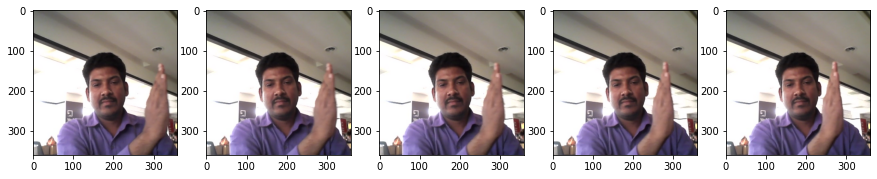


Resized Image: (360,360,3) to (120,120,3) - No cropping


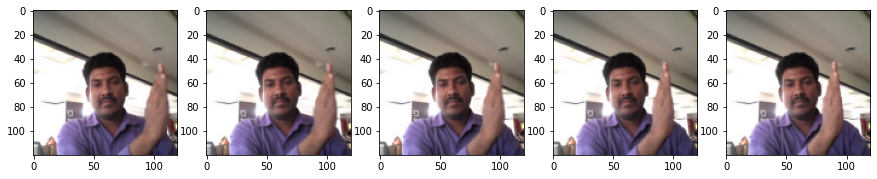

In [32]:
# Resizing images with shape (360,360,3) to a shape of (120,120,3)

# Obtain path - Using the same random sequence we saw earlier.
sample_path2 = os.path.join(base_dir,'Project_data/train', train_doc[614].split(';')[0], '*')
sample_path2 = glob.glob(sample_path2)
sample_path2 = sorted(sample_path2, key=lambda x: os.path.splitext(os.path.basename(x))[0])

# Visualizing the first 5 frames of the sequence as it is
print("\nOriginal Image: (360,360,3)")
plt.figure(figsize=(15,10))
for i in range(5):
  plt.subplot(1,5,i+1)
  image = imread(sample_path2[i])
  plt.imshow(image)
plt.show()

# Visualizing the first 5 frames of the sequence after resizing to (120,120,3) - No cropping
print("\nResized Image: (360,360,3) to (120,120,3) - No cropping")
plt.figure(figsize=(15,10))
for i in range(5):
  plt.subplot(1,5,i+1)
  image = imread(sample_path2[i])
  image = resize(image, (120,120,3))
  plt.imshow(image)
plt.show()

- We can see that resizing the images from (360,360,3) to a lower size of (120,120,3) **does not** noticeably deteriorate the image, at least visually. 
- All/most of the features we want to capture is more or less in tact. 
- Hence, we should go ahead with the resizing to significantly reduce the amount of training required.

- **We shall start off with an input image shape of (120,120,3) and either increase or decrease the preferred shape (pref_shape) of input images as required.**

## Generator

- The generator function(s) defined below can adapt to changes in preferences for the following parameters:
    - Batch sizes
    - No. of frames per sequence to be included.
    - Preferred input shape of the images. As seen in EDA above, the images in the data can be of 2 shapes and may need to be resized/cropped.
    - Option to crop the images, if so desired.

- The generator function has been split into 2 parts
    - "generator": Primary function called prior to model training
    - "obtain_batch": Secondary function which actually does the heavy lifting of generating a batch of data.

In [33]:
# Primary generator function called prior to model training.
# The function can adapt to different batch sizes, image shapes, cropping preference and no. of desired frames per sequence when evoked.

def generator(source_path, folder_list, batch_size, num_frames=30, pref_shape = (120, 120, 3), crop = 'False'):
    #print('\nSource path = ', source_path, '; batch size =', batch_size)
    
    # Creating a framework where the indexes of the images generated are based on the number of frames chosen and are centred around the centre of the complete sequence.
    # The logic for doing this is that most of the valuable information in a sequence is likely to be in the middle of the sequence rather than in the first few or last few frames.
    # If all 30 frames are to be included, index would be from 0 to 29.
    # If 18 frames per sequence are chosen, indexes would be from 6 to 23.
    
    idx_start = 15 - num_frames // 2
    if num_frames % 2 == 0:
      idx_end = 15 + num_frames // 2 - 1
    else:
      idx_end = 15 + num_frames // 2
    img_idx = [i for i in range(idx_start,idx_end + 1)] #create a list of image numbers you want to use for a particular video
    
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t) // batch_size # calculate the number of batches
        
        # Generating full-sized batches (except last batch)
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data, batch_labels = obtain_batch(source_path, t, batch, batch_size, img_idx, pref_shape)
            yield batch_data, batch_labels

        # Generating the last batch
        remainder = len(t) % batch_size

        if remainder != 0:
            batch_data, batch_labels = obtain_batch(source_path, t, num_batches, remainder, img_idx, pref_shape)
            yield batch_data, batch_labels

In [34]:
# Secondary generator function called by the primary generator function above to generate a batch of data.
# This function performs the dual tasks of generating both full size batches as well as smaller remainder batches depending on which part of the generator function evokes it.

def obtain_batch(source_path, t, batch, batch_size, img_idx, pref_shape, crop = 'False'):

    batch_data = np.zeros((batch_size, len(img_idx), pref_shape[0], pref_shape[1], pref_shape[2]))
    batch_labels = np.zeros((batch_size,5))
    for folder in range(batch_size):
        
        # read the names of images in the folders of current batch
        imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])
        
        # Sorting the image names in order of the frames. They can be jumbled up as seen earlier during EDA.
        imgs = sorted(imgs, key=lambda img: os.path.splitext(os.path.basename(img))[0]) 
        
        for idx,item in enumerate(img_idx):                                               #  Iterate over the frames/images of a folder to read them in
            # Read images one at a time for current batch .
            image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
            
            # Resize / Crop
            if crop == "False":
                # Simply resize the image. No cropping applied.
                image = resize(image, pref_shape)

            else:
                # Resize / crop the images based on original image shape since the training and validation data consists of two image dimensions
                if image.shape == (120,160,3):
                    # Crop the sides of the image which is rectangular to make it a square shape. This would resize to our chosen desired dimensions as well.
                    image = image[:,20:image.shape[1] - 20,:]
            
                # Resize the image to preferred shape "pref_shape"
                image = resize(image, pref_shape)
                                      
            # Normalize images
            batch_data[folder,idx,:,:,0] = image[:,:,0] / 255 #normalise and feed in the image
            batch_data[folder,idx,:,:,1] = image[:,:,1] / 255 #normalise and feed in the image
            batch_data[folder,idx,:,:,2] = image[:,:,2] / 255 #normalise and feed in the image
                    
        batch_labels[folder, int(t[folder + batch*batch_size].strip().split(';')[2])] = 1
    
    return (batch_data, batch_labels)

## Functions for model training, callbacks definition etc.

- While calling this function, most of the arguments remain the same from model to model. The only arguments which need to be updated are:
    - "model": The model architecture defined immediately before this function is called
    - "batch_size": Self- explanatory
    - "num_epochs": No. of epochs of training to be run.
    - "num_frames": No. of frames per sequence to be considered for training. Can stay mostly constant unless results are poor
    - "pref_shape": Preferred shape of the images input to the model. The images are then resized accordingly in the generator function.
    - "crop": True or False, If true, the non-square images would be cropped by 20 pixels each from left and right to bring them to a square shape.

- The function also has callbacks defined for later use.
    - Checkpoint for saving the best weights and architecture of the model as an '.h5' file.
    - Reducing the learning rate if a plateau is encountered in evaluation metrics (val_loss)
    - Early Stopping after 10 continuous epochs of very little improvement in val_loss.
    
- The function finally 'fits' the training data as required.
- The function avoids the need of re-running all of the steps within for each model and can simply be invoked whenever a model needs to be trained.

In [37]:
# Function to train(fit) the model

def train_model(model, train_path, train_doc, val_path, val_doc, num_train_sequences, num_val_sequences, num_epochs, 
                batch_size = 32, num_frames=30, pref_shape=(120,120,3),crop = 'False'):
    
    train_generator = generator(train_path, train_doc, batch_size, num_frames, pref_shape, crop)
    val_generator = generator(val_path, val_doc,  batch_size, num_frames, pref_shape, crop)

    #model_name = str(base_dir) + '/Project_data/model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    model_name = '/home/dl_content/Upgrad_DL/Gesture_Recognition_Assignment/Models/model_init' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
    if not os.path.exists(model_name):
        os.mkdir(model_name)
        
    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

    # Callbacks list for history recording.
    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq = 'epoch')
    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.3, verbose=1, patience=4)
    earlystop = EarlyStopping( monitor="val_loss", min_delta=0.0005, patience=10, verbose=1)
    callbacks_list = [checkpoint, LR, earlystop]

    if (num_train_sequences % batch_size) == 0:
        steps_per_epoch = int(num_train_sequences / batch_size)
    else:
        steps_per_epoch = (num_train_sequences // batch_size) + 1

    if (num_val_sequences % batch_size) == 0:
        validation_steps = int(num_val_sequences / batch_size)
    else:
        validation_steps = (num_val_sequences // batch_size) + 1
    
    history=model.fit(train_generator, steps_per_epoch = steps_per_epoch, epochs = num_epochs, verbose=1, callbacks = callbacks_list, 
                      validation_data = val_generator, validation_steps = validation_steps, class_weight=None, workers=1, initial_epoch=0)
    return history

In [38]:
# Function to plot the results of training and validation metrics.

def plot_results(history, epochs):

  acc = history.history['categorical_accuracy']
  val_acc = history.history['val_categorical_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(1,epochs+1)

  plt.figure(figsize=(16, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')
  plt.ylabel("Accuracy")
  plt.xlabel("No. of Epochs")

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.ylabel("Loss")
  plt.xlabel("No. of Epochs")

  plt.show()

In [39]:
# Defining some global variables and paths

train_path = str(base_dir) + '/Project_data/train'
val_path = str(base_dir) + '/Project_data/val'

num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)

num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

num_classes = 5
print('# classes =', num_classes)

# training sequences = 663
# validation sequences = 100
# classes = 5


## Testing the generator

In [40]:
# Initial test
batch_size_test = 32
num_frame_test = 18
pref_shape_test = (120,160,3)

test_gen = generator(val_path, val_doc, batch_size_test, num_frame_test, pref_shape_test)
#for i in range(1,num_val_sequences//batch_size_test + 1):
batch_data, batch_labels=next(test_gen)
print("Batch no. {0} shape: {1}\n".format(1,batch_data.shape))
print("\n Label of 1st data point within batch: ",batch_labels[0,:])

Batch no. 1 shape: (32, 18, 120, 160, 3)


 Label of 1st data point within batch:  [0. 0. 0. 1. 0.]


In [41]:
# Second batch
batch_data, batch_labels=next(test_gen)
print("Batch no. {0} shape: {1}\n".format(2,batch_data.shape))
print("\n Label of 2nd data point within batch: ",batch_labels[0,:])

Batch no. 2 shape: (32, 18, 120, 160, 3)


 Label of 2nd data point within batch:  [0. 0. 1. 0. 0.]


No. of sequences in validation data:  100
No. of batches:  4

Batch no. 1 shape: (32, 18, 120, 120, 3)
Label for first data boint of batch1: [0. 0. 0. 0. 1.]


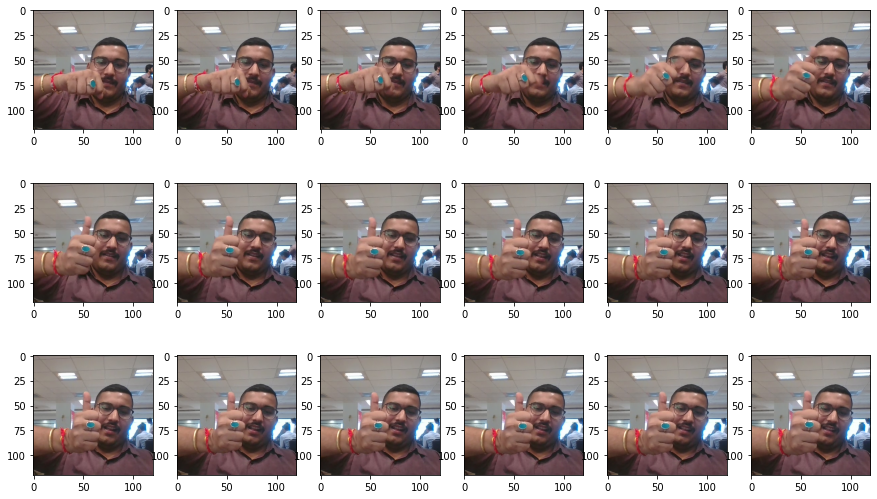


Batch no. 2 shape: (32, 18, 120, 120, 3)
Label for first data boint of batch2: [1. 0. 0. 0. 0.]


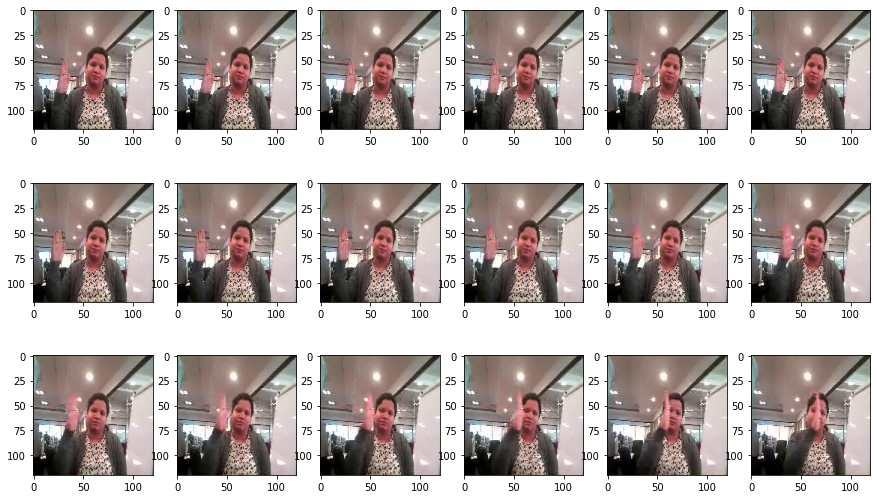


Batch no. 3 shape: (32, 18, 120, 120, 3)
Label for first data boint of batch3: [0. 1. 0. 0. 0.]


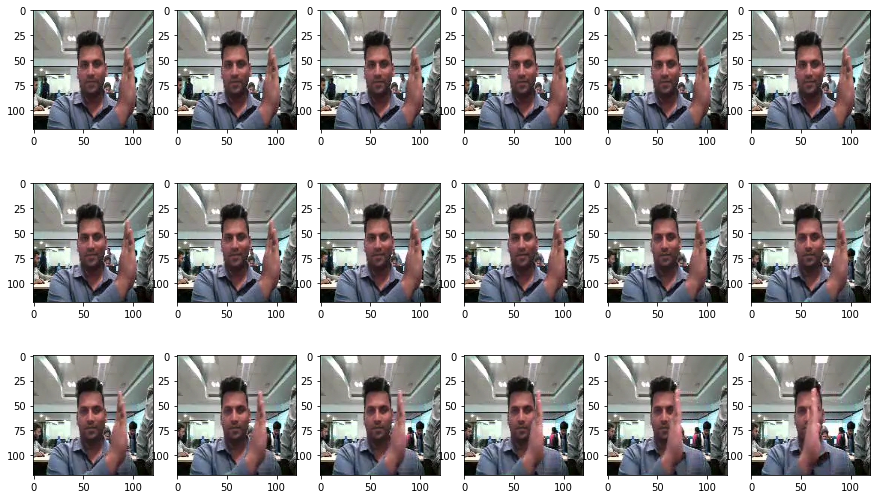


Batch no. 4 shape: (4, 18, 120, 120, 3)
Label for first data boint of batch4: [0. 1. 0. 0. 0.]


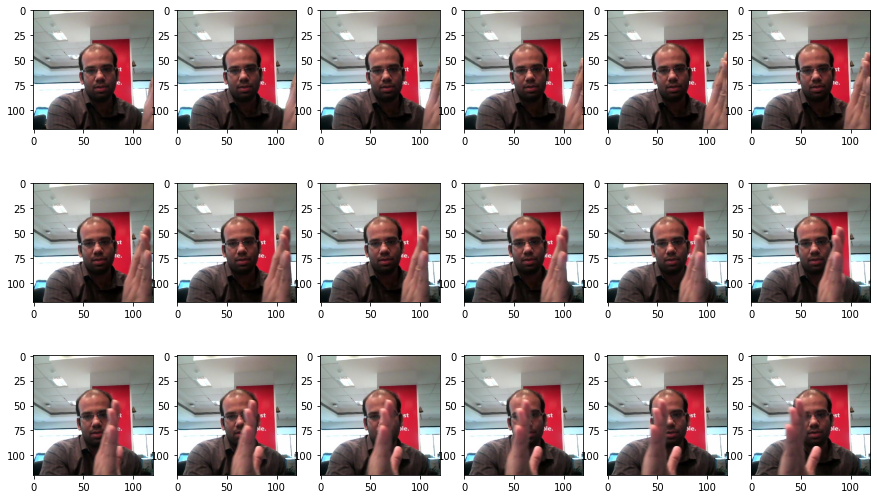

In [45]:
# Display first data point from each batch of validation data
batch_size_test = 32
num_frame_test = 18
pref_shape_test = (120,120,3)

print("No. of sequences in validation data: ", num_val_sequences)
print("No. of batches: ",num_val_sequences//batch_size_test + 1)

test_gen = generator(val_path, val_doc, batch_size_test, num_frame_test, pref_shape_test)

for i in range(num_val_sequences//batch_size_test + 1):
  batch_data, batch_labels=next(test_gen)
  print("\nBatch no. {0} shape: {1}".format(i+1,batch_data.shape))
  print("Label for first data boint of batch{0}: {1}".format(i+1,batch_labels[0,:]))
  plt.figure(figsize = (15,9))
  for j in range(num_frame_test):
    plt.subplot(num_frame_test//6,num_frame_test//3,j+1)
    plt.imshow(batch_data[0,j,:,:,:])
  plt.show()

## Initial memory experiments

- Experiments for batch size, input shape etc for optimal usage of GPU memory and / or RAM.
- Please note that the kernal had to be restarted after each experiment because the RAM would be saturated from previous experiment, irrespective of whether the model successfully ran or not.

### Model 0 

In [13]:
# Defining an initial model with 4 Conv3D layers + 2 fully-connected layers + 1 softmax output layer.
def model_zero(train_path, train_doc, val_path, val_doc, num_train_sequences, num_val_sequences, num_epochs, batch_size, num_frames, pref_shape):
    
    model0 = Sequential()

    model0.add(Conv3D(16, kernel_size=(3,3,3), padding ='same', 
                  input_shape = (num_frames,pref_shape[0],pref_shape[1],pref_shape[2])))
    model0.add(Activation('relu'))
    model0.add(MaxPooling3D(pool_size=(2,2,2)))

    model0.add(Conv3D(32, kernel_size=(3,3,3), padding ='same'))
    model0.add(Activation('relu'))
    model0.add(MaxPooling3D(pool_size=(2,2,2)))

    model0.add(Conv3D(64, kernel_size=(3,3,3), padding ='same'))
    model0.add(Activation('relu'))
    model0.add(MaxPooling3D(pool_size=(2,2,2)))

    model0.add(Conv3D(128, kernel_size=(3,3,3), padding ='same'))
    model0.add(Activation('relu'))
    model0.add(MaxPooling3D(pool_size=(2,2,2)))

    model0.add(Flatten())
    model0.add(Dense(128, activation = 'relu'))
    model0.add(BatchNormalization())
    model0.add(Dropout(0.25))

    model0.add(Dense(128, activation = 'relu'))
    model0.add(BatchNormalization())
    model0.add(Dropout(0.25))

    model0.add(Dense(num_classes, activation = 'softmax'))

    optimiser = optimizers.Adam() #write your optimizer
    model0.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

    # View the summary of all layers
    # model0.summary()
    
    # Obtain the training and validation generators
    train_generator = generator(train_path, train_doc, batch_size, num_frames, pref_shape)
    val_generator = generator(val_path, val_doc,  batch_size, num_frames, pref_shape)

    # Fitting the model for 1 epoch to see if it runs
    if (num_train_sequences % batch_size) == 0:
        steps_per_epoch = int(num_train_sequences / batch_size)
    else:
        steps_per_epoch = (num_train_sequences // batch_size) + 1

    if (num_val_sequences % batch_size) == 0:
        validation_steps = int(num_val_sequences / batch_size)
    else:
        validation_steps = (num_val_sequences // batch_size) + 1

    model0.fit(train_generator, steps_per_epoch = steps_per_epoch, epochs = 1, initial_epoch=0, verbose=1,
               validation_data = val_generator, validation_steps = validation_steps, class_weight=None, workers=1)
    

Testing the following hyperparameters for memory compatibility:
- **Batch size: 256 / 128 / 64 / 32**
- **Number of frames: 30 / 20**
- Using preferred shape of images for input to the model as (120,120,3)

In [23]:
# Test 1: Batch size = 256, No. of frames per sequence = 30
batch_size = 256
num_frames = 30

pref_shape = (120,120,3)
num_epochs = 1

model_zero(train_path, train_doc, val_path, val_doc, num_train_sequences, num_val_sequences, num_epochs, batch_size, num_frames, pref_shape)

ResourceExhaustedError:  OOM when allocating tensor with shape[256,30,120,120,16] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node sequential/activation/Relu-0-1-TransposeNCDHWToNDHWC-LayoutOptimizer}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_1622]

Function call stack:
train_function


In [15]:
# Test 2: Batch size = 128, No. of frames per sequence = 30
batch_size = 128
num_frames = 30

pref_shape = (120,120,3)
num_epochs = 1

model_zero(train_path, train_doc, val_path, val_doc, num_train_sequences, num_val_sequences, num_epochs, batch_size, num_frames, pref_shape)

ResourceExhaustedError:  OOM when allocating tensor with shape[128,16,30,120,120] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node gradient_tape/sequential/max_pooling3d/MaxPool3D/MaxPool3DGrad (defined at <ipython-input-14-2fac126f9b49>:56) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_1622]

Function call stack:
train_function


In [14]:
# Test 3: Batch size = 128, No. of frames per sequence = 20
batch_size = 128
num_frames = 20

pref_shape = (120,120,3)
num_epochs = 1

model_zero(train_path, train_doc, val_path, val_doc, num_train_sequences, num_val_sequences, num_epochs, batch_size, num_frames, pref_shape)

ResourceExhaustedError:  OOM when allocating tensor with shape[128,16,20,120,120] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node gradient_tape/sequential/max_pooling3d/MaxPool3D/MaxPool3DGrad (defined at <ipython-input-13-2fac126f9b49>:56) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_1622]

Function call stack:
train_function


In [14]:
# Test 4: Batch size = 64, No. of frames per sequence = 30
batch_size = 64
num_frames = 30

pref_shape = (120,120,3)
num_epochs = 1

model_zero(train_path, train_doc, val_path, val_doc, num_train_sequences, num_val_sequences, num_epochs, batch_size, num_frames, pref_shape)

11/11 [==============================] - 142s 13s/step - loss: 1.7666 - categorical_accuracy: 0.3590 - val_loss: 2.8377 - val_categorical_accuracy: 0.1900


In [16]:
! nvidia-smi

Sat Sep 25 06:32:11 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 470.42.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 5000     Off  | 00000000:1B:00.0 Off |                  Off |
| 33%   49C    P2    46W / 230W |  15700MiB / 16125MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [14]:
# Test 5: Batch size = 64, No. of frames per sequence = 20
batch_size = 64
num_frames = 20

pref_shape = (120,120,3)
num_epochs = 1

model_zero(train_path, train_doc, val_path, val_doc, num_train_sequences, num_val_sequences, num_epochs, batch_size, num_frames, pref_shape)

11/11 [==============================] - 95s 9s/step - loss: 1.8039 - categorical_accuracy: 0.3484 - val_loss: 3.1731 - val_categorical_accuracy: 0.1800


In [16]:
! nvidia-smi

Sat Sep 25 05:38:11 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 470.42.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 5000     Off  | 00000000:1B:00.0 Off |                  Off |
| 33%   47C    P2    45W / 230W |   9592MiB / 16125MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [14]:
# Test 6: Batch size = 32, No. of frames per sequence = 30
batch_size = 32
num_frames = 30

pref_shape = (120,120,3)
num_epochs = 1

model_zero(train_path, train_doc, val_path, val_doc, num_train_sequences, num_val_sequences, num_epochs, batch_size, num_frames, pref_shape)

21/21 [==============================] - 144s 7s/step - loss: 1.7322 - categorical_accuracy: 0.3544 - val_loss: 4.4372 - val_categorical_accuracy: 0.2100


In [15]:
! nvidia-smi

Sat Sep 25 05:41:45 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 470.42.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 5000     Off  | 00000000:1B:00.0 Off |                  Off |
| 33%   47C    P2    45W / 230W |   9592MiB / 16125MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#### Memory test conclusions:
- Higher batch sizes of 256 & 128 resulted in Out of Memory (OOM) error, even with reduced no. of frames per sequence.
- There was a slight trade-off seen between batch-size and no. of frames per sequence used when it came to memory usage.
- **Ideally, we would like to include all 30 frames per sequence to include maximum information from the input data.**
- The following possible combinations of batch size may be considered for usage:
    1. Batch size: 64, No. of frames: 30
    2. Batch size: 32, No. of frames: 30
    3. Batch size: 64, No. of frames: 20 (Only use if further memory issues encountered.)

## Models
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

## 3D Convolutional Neural Networks

### Model 1 : Base model
- Architecture
    - 4 x Conv3D layers
    - 2 x Fully-connected layers
    - Output softmax layer
    - Activation function used: Relu
    - Optimizer: Adam (with default learning rate)
- Batch Size: 64
- No. of frames per sequence: 30
- Input image shape: (120,120,3)

In [13]:
# Defining hyperparameters for model 1
batch_size = 64
print("Batch_size: ",batch_size)

num_frames = 30
print("# frames per sequence: ", num_frames)

pref_shape = (120, 120, 3)
print("Shape of all images: ", pref_shape)

# choose the number of epochs
num_epochs = 20
print ('# epochs =', num_epochs)

Batch_size:  64
# frames per sequence:  30
Shape of all images:  (120, 120, 3)
# epochs = 20


In [14]:
model1 = Sequential()

model1.add(Conv3D(16, kernel_size=(3,3,3), padding ='same', 
                  input_shape = (num_frames,pref_shape[0],pref_shape[1],pref_shape[2])))
model1.add(Activation('relu'))
model1.add(MaxPooling3D(pool_size=(2,2,2)))

model1.add(Conv3D(32, kernel_size=(3,3,3), padding ='same'))
model1.add(Activation('relu'))
model1.add(MaxPooling3D(pool_size=(2,2,2)))

model1.add(Conv3D(64, kernel_size=(3,3,3), padding ='same'))
model1.add(Activation('relu'))
model1.add(MaxPooling3D(pool_size=(2,2,2)))

model1.add(Conv3D(128, kernel_size=(3,3,3), padding ='same'))
model1.add(Activation('relu'))
model1.add(MaxPooling3D(pool_size=(2,2,2)))

model1.add(Flatten())
model1.add(Dense(128, activation = 'relu'))
model1.add(Dropout(0.25))

model1.add(Dense(128, activation = 'relu'))
model1.add(Dropout(0.25))

model1.add(Dense(num_classes, activation = 'softmax'))

optimiser = optimizers.Adam()
model1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# View the summary of all layers
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 30, 120, 120, 16)  1312      
_________________________________________________________________
activation (Activation)      (None, 30, 120, 120, 16)  0         
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 15, 60, 60, 16)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 15, 60, 60, 32)    13856     
_________________________________________________________________
activation_1 (Activation)    (None, 15, 60, 60, 32)    0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 7, 30, 30, 32)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 7, 30, 30, 64)     5

In [15]:
# Train the model
history1 = train_model(model1, train_path, train_doc, val_path, val_doc, num_train_sequences, num_val_sequences, num_epochs, batch_size, num_frames, pref_shape)

Epoch 1/20
11/11 [==============================] - ETA: 0s - loss: 1.6080 - categorical_accuracy: 0.2353 
Epoch 00001: val_loss improved from inf to 1.59420, saving model to /home/dl_content/Upgrad_DL/Gesture_Recognition_Assignment/Models/model_init2021-09-2505_43_39.249499/model-00001-1.60799-0.23529-1.59420-0.20000.h5
11/11 [==============================] - 143s 13s/step - loss: 1.6080 - categorical_accuracy: 0.2353 - val_loss: 1.5942 - val_categorical_accuracy: 0.2000
Epoch 2/20
11/11 [==============================] - ETA: 0s - loss: 1.5872 - categorical_accuracy: 0.2247 
Epoch 00002: val_loss improved from 1.59420 to 1.51902, saving model to /home/dl_content/Upgrad_DL/Gesture_Recognition_Assignment/Models/model_init2021-09-2505_43_39.249499/model-00002-1.58720-0.22474-1.51902-0.22000.h5
11/11 [==============================] - 142s 13s/step - loss: 1.5872 - categorical_accuracy: 0.2247 - val_loss: 1.5190 - val_categorical_accuracy: 0.2200
Epoch 3/20
11/11 [======================

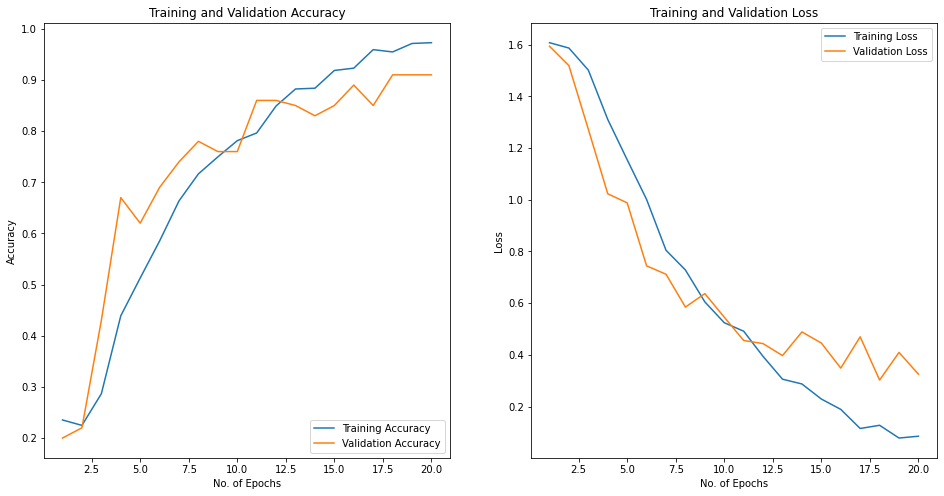

In [17]:
# Plot model 1 results
plot_results(history1, num_epochs)

#### Model 1 comments:
- Best metrics obtained:
    - Training Accuracy: 0.9548
    - Validation Accuracy: 0.9100
    - Training loss: 0.1275
    - Validation loss: 0.3025

- This is an excellent first model from the results above,  with very good training and validation accuracy results with very little overfitting.
- Including all the 30 frames in each sequence seems to be working well, as is our input shape of (120,120,3), to which the original images are resized. We shall stick to these parameters unless there is a significant drop to the accuracy values, warranting a change.
- A batch size of 64 is just about able to be fit in memory.
- Total params: 1,111,941. We can potentially look at reducing the number of parameters by reducing the width of some layers.

**---------------------------------------------------------------------------------------------------------------------------------------------------------**

### Model 2 - Test for cropping of images.

- Cropping the images with shape (120,160,3), 20 pixels from each side, to bring it to shape (120,120,3)
- Architecture (Same as model 1)
    - 4 x Conv3D layers
    - 2 x Fully-connected layers
    - Output softmax layer
    - Activation function used: Relu
    - Optimizer: Adam (with default learning rate)
- Batch Size: 64
- No. of frames per sequence: 30
- Input image shape: (120,120,3)

In [13]:
# Defining hyperparameters for model 2
batch_size = 64
print("Batch_size: ",batch_size)

num_frames = 30
print("# frames per sequence: ", num_frames)

pref_shape = (120, 120, 3)
print("Shape of all images: ", pref_shape)

# choose the number of epochs
num_epochs = 20
print ('# epochs =', num_epochs)

Batch_size:  64
# frames per sequence:  30
Shape of all images:  (120, 120, 3)
# epochs = 20


In [14]:
model2 = Sequential()

model2.add(Conv3D(16, kernel_size=(3,3,3), padding ='same', 
                  input_shape = (num_frames,pref_shape[0],pref_shape[1],pref_shape[2])))
model2.add(Activation('relu'))
#model2.add(BatchNormalization())
model2.add(MaxPooling3D(pool_size=(2,2,2)))

model2.add(Conv3D(32, kernel_size=(3,3,3), padding ='same'))
model2.add(Activation('relu'))
#model2.add(BatchNormalization())
model2.add(MaxPooling3D(pool_size=(2,2,2)))

model2.add(Conv3D(64, kernel_size=(3,3,3), padding ='same'))
model2.add(Activation('relu'))
#model2.add(BatchNormalization())
model2.add(MaxPooling3D(pool_size=(2,2,2)))

model2.add(Conv3D(128, kernel_size=(3,3,3), padding ='same'))
model2.add(Activation('relu'))
#model2.add(BatchNormalization())
model2.add(MaxPooling3D(pool_size=(2,2,2)))

model2.add(Flatten())
model2.add(Dense(128, activation = 'relu'))
#model2.add(BatchNormalization())
model2.add(Dropout(0.25))

model2.add(Dense(128, activation = 'relu'))
#model2.add(BatchNormalization())
model2.add(Dropout(0.25))

model2.add(Dense(num_classes, activation = 'softmax'))

optimiser = optimizers.Adam()
model2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# View the summary of all layers
model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 30, 120, 120, 16)  1312      
_________________________________________________________________
activation (Activation)      (None, 30, 120, 120, 16)  0         
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 15, 60, 60, 16)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 15, 60, 60, 32)    13856     
_________________________________________________________________
activation_1 (Activation)    (None, 15, 60, 60, 32)    0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 7, 30, 30, 32)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 7, 30, 30, 64)     5

In [15]:
# Train the model
crop = 'True'
history2 = train_model(model2, train_path, train_doc, val_path, val_doc, num_train_sequences, num_val_sequences, num_epochs, batch_size, num_frames, pref_shape, crop)

Epoch 1/20
11/11 [==============================] - ETA: 0s - loss: 1.6082 - categorical_accuracy: 0.2368 
Epoch 00001: val_loss improved from inf to 1.59634, saving model to /home/dl_content/Upgrad_DL/Gesture_Recognition_Assignment/Models/model_init2021-09-2506_35_39.488386/model-00001-1.60820-0.23680-1.59634-0.20000.h5
11/11 [==============================] - 147s 13s/step - loss: 1.6082 - categorical_accuracy: 0.2368 - val_loss: 1.5963 - val_categorical_accuracy: 0.2000
Epoch 2/20
11/11 [==============================] - ETA: 0s - loss: 1.5896 - categorical_accuracy: 0.2338 
Epoch 00002: val_loss improved from 1.59634 to 1.52722, saving model to /home/dl_content/Upgrad_DL/Gesture_Recognition_Assignment/Models/model_init2021-09-2506_35_39.488386/model-00002-1.58964-0.23379-1.52722-0.23000.h5
11/11 [==============================] - 146s 13s/step - loss: 1.5896 - categorical_accuracy: 0.2338 - val_loss: 1.5272 - val_categorical_accuracy: 0.2300
Epoch 3/20
11/11 [======================

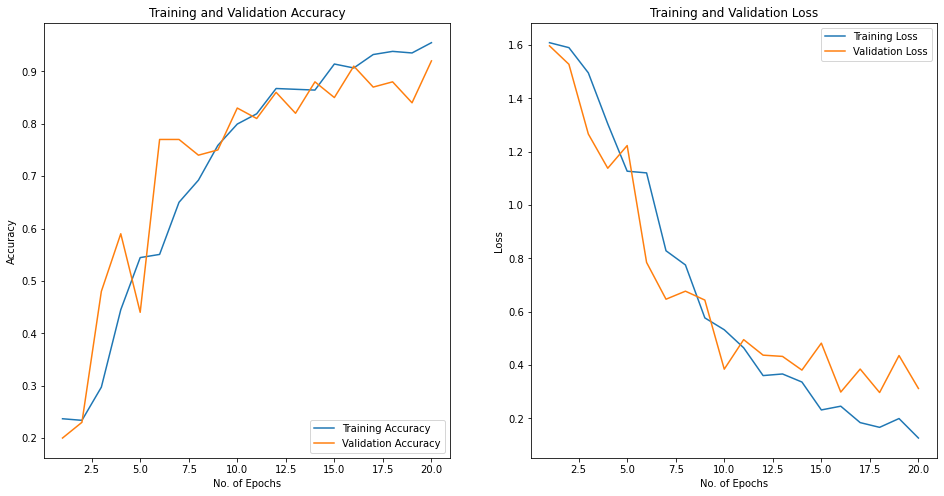

In [16]:
plot_results(history2, num_epochs)

#### Model 2 comments:
- Best metrics obtained:
    - Training Accuracy: 0.9382
    - Validation Accuracy: 0.8800
    - Training loss: 0.1664
    - Validation loss: 0.2970

- There isn't much to choose from between model 1 and model 2 with both models providing similar results.
- If anything, cropping some of the images very slightly deteriorates the results. This is expected as we are losing some information by cropping.
- Henceforth, we shall avoid cropping any of the images and would stick to simply resizing both the shapes of images to our preferred input shape for retention of all/most image information.

**---------------------------------------------------------------------------------------------------------------------------------------------------------**

### Model 3
- Increasing the number of conv3D layers to see the results
- Architecture
    - 8 x Conv3D layers
    - 2 x Fully-connected layers
    - Output softmax layer
    - Activation function used: Relu
    - Optimizer: Adam (with default learning rate)
- Batch Size: 64
- No. of frames per sequence: 30
- Input image shape: (120,120,3)



In [ ]:
# Defining hyperparameters for model 3
batch_size = 64
print("Batch_size: ",batch_size)

num_frames = 30
print("# frames per sequence: ", num_frames)

pref_shape = (120, 120, 3)
print("Shape of all images: ", pref_shape)

# choose the number of epochs
num_epochs = 15
print ('# epochs =', num_epochs)

Batch_size:  64
# frames per sequence:  30
Shape of all images:  (120, 120, 3)
# epochs = 15


In [ ]:
model3 = Sequential()

model3.add(Conv3D(16, kernel_size=(3,3,3), padding ='same', activation = 'relu', 
                  input_shape = (num_frames,pref_shape[0],pref_shape[1],pref_shape[2])))

model3.add(Conv3D(16, kernel_size=(3,3,3), padding ='same', activation = 'relu'))
model3.add(MaxPooling3D(pool_size=(2,2,2)))

model3.add(Conv3D(32, kernel_size=(3,3,3), padding ='same', activation = 'relu'))
model3.add(Conv3D(32, kernel_size=(3,3,3), padding ='same', activation = 'relu'))
model3.add(MaxPooling3D(pool_size=(2,2,2)))

model3.add(Conv3D(64, kernel_size=(3,3,3), padding ='same', activation = 'relu'))
model3.add(Conv3D(64, kernel_size=(3,3,3), padding ='same', activation = 'relu'))
model3.add(MaxPooling3D(pool_size=(2,2,2)))

model3.add(Conv3D(128, kernel_size=(3,3,3), padding ='same', activation = 'relu'))
model3.add(Conv3D(128, kernel_size=(3,3,3), padding ='same', activation = 'relu'))
model3.add(MaxPooling3D(pool_size=(2,2,2)))

model3.add(Flatten())
model3.add(Dense(256, activation = 'relu'))
model3.add(Dropout(0.25))

model3.add(Dense(256, activation = 'relu'))
model3.add(Dropout(0.25))

model3.add(Dense(num_classes, activation = 'softmax'))

optimiser = optimizers.Adam() #write your optimizer
model3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# View the summary of all layers
model3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 30, 120, 120, 16)  1312      
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 30, 120, 120, 16)  6928      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 15, 60, 60, 16)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 15, 60, 60, 32)    13856     
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 15, 60, 60, 32)    27680     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 7, 30, 30, 32)     0         
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 7, 30, 30, 64)     5

In [ ]:
# Train the model
history3 = train_model(model3, train_path, train_doc, val_path, val_doc, num_train_sequences, num_val_sequences, num_epochs, batch_size, num_frames, pref_shape)

Epoch 1/15
11/11 [==============================] - ETA: 0s - loss: 1.6551 - categorical_accuracy: 0.1946 
Epoch 00001: val_loss improved from inf to 1.61055, saving model to /home/dl_content/Upgrad_DL/Gesture_Recognition_Assignment/model_init2021-09-2311_09_27.169543/model-00001-1.65514-0.19457-1.61055-0.19000.h5
11/11 [==============================] - 144s 13s/step - loss: 1.6551 - categorical_accuracy: 0.1946 - val_loss: 1.6106 - val_categorical_accuracy: 0.1900
Epoch 2/15
11/11 [==============================] - ETA: 0s - loss: 1.6095 - categorical_accuracy: 0.1855 
Epoch 00002: val_loss improved from 1.61055 to 1.60388, saving model to /home/dl_content/Upgrad_DL/Gesture_Recognition_Assignment/model_init2021-09-2311_09_27.169543/model-00002-1.60950-0.18552-1.60388-0.20000.h5
11/11 [==============================] - 146s 13s/step - loss: 1.6095 - categorical_accuracy: 0.1855 - val_loss: 1.6039 - val_categorical_accuracy: 0.2000
Epoch 3/15
11/11 [==============================] - ET

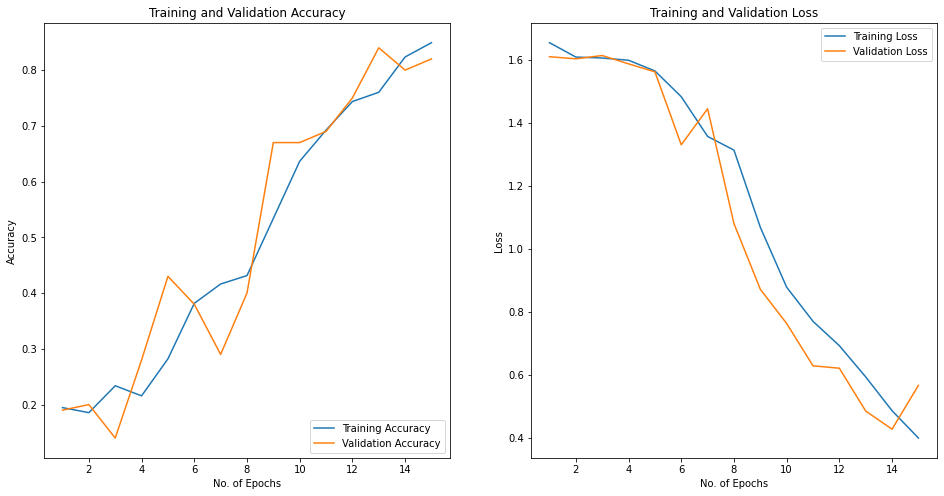

In [ ]:
# Plotting results for model 3 for first 15 epochs.
plot_results(history3, num_epochs)

In [ ]:
# Running model 3 for another 10 epochs for a total of 25 epochs
history3 = train_model(model3, train_path, train_doc, val_path, val_doc, num_train_sequences, num_val_sequences, 10, batch_size, num_frames, pref_shape)

Epoch 1/10
11/11 [==============================] - ETA: 0s - loss: 0.5829 - categorical_accuracy: 0.7888 
Epoch 00001: val_loss improved from inf to 0.68909, saving model to /home/dl_content/Upgrad_DL/Gesture_Recognition_Assignment/model_init2021-09-2311_47_25.251231/model-00001-0.58289-0.78884-0.68909-0.75000.h5
11/11 [==============================] - 152s 14s/step - loss: 0.5829 - categorical_accuracy: 0.7888 - val_loss: 0.6891 - val_categorical_accuracy: 0.7500
Epoch 2/10
11/11 [==============================] - ETA: 0s - loss: 0.4387 - categorical_accuracy: 0.8477 
Epoch 00002: val_loss improved from 0.68909 to 0.38560, saving model to /home/dl_content/Upgrad_DL/Gesture_Recognition_Assignment/model_init2021-09-2311_47_25.251231/model-00002-0.43873-0.84766-0.38560-0.83000.h5
11/11 [==============================] - 145s 13s/step - loss: 0.4387 - categorical_accuracy: 0.8477 - val_loss: 0.3856 - val_categorical_accuracy: 0.8300
Epoch 3/10
11/11 [==============================] - ET

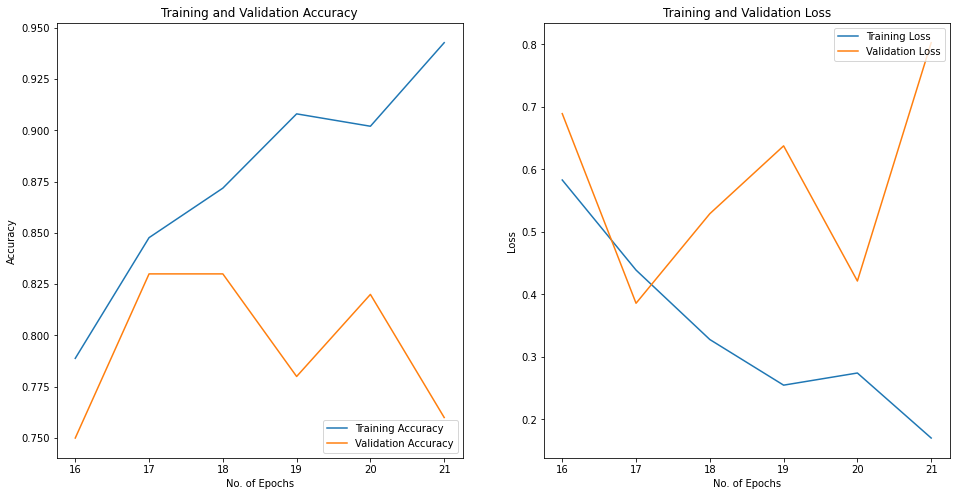

In [ ]:
# Plot model 3 results - Epoch 16 to 25
  acc = history3.history['categorical_accuracy']
  val_acc = history3.history['val_categorical_accuracy']

  loss = history3.history['loss']
  val_loss = history3.history['val_loss']

  epochs_range = range(16,22)

  plt.figure(figsize=(16, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')
  plt.ylabel("Accuracy")
  plt.xlabel("No. of Epochs")

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.ylabel("Loss")
  plt.xlabel("No. of Epochs")

  plt.show()

#### Model 3 comments:
- Best metrics obtained:
    - Training Accuracy: 0.8477
    - Validation Accuracy: 0.8300
    - Training loss: 0.4387
    - Validation loss: 0.3856

- The addition of more convolutional layers does not provide any significant improvement as compared to Model 1 after 15 epochs and significantly increases run time.
- However, with higher number of epochs we see that the rmodel starts to overfit. **This leads us to believe that model 1 with a simpler architecture and lesser number of parameters would be able to perform equally better.**

**---------------------------------------------------------------------------------------------------------------------------------------------------------**

### Model 4
- Reducing the width of the fully-connected layers to 64 neurons as compared to model 1. This significantly reduces the number of trainable parameters in the network.
- Architecture
    - 4 x Conv3D layers
    - 2 x Fully-connected layers (64 neurons each)
    - Output softmax layer
    - Activation function used: Relu
    - Optimizer: Adam (with default learning rate)
- Batch Size: 64
- No. of frames per sequence: 30
- Input image shape: (120,120,3)

In [13]:
# Defining hyperparameters for model 4
batch_size = 64
print("Batch_size: ",batch_size)

num_frames = 30
print("# frames per sequence: ", num_frames)

pref_shape = (120, 120, 3)
print("Shape of all images: ", pref_shape)

# choose the number of epochs
num_epochs = 20
print ('# epochs =', num_epochs)

Batch_size:  64
# frames per sequence:  30
Shape of all images:  (120, 120, 3)
# epochs = 20


In [14]:
model4 = Sequential()

model4.add(Conv3D(16, kernel_size=(3,3,3), padding ='same', 
                  input_shape = (num_frames,pref_shape[0],pref_shape[1],pref_shape[2])))
model4.add(Activation('relu'))
model4.add(MaxPooling3D(pool_size=(2,2,2)))

model4.add(Conv3D(32, kernel_size=(3,3,3), padding ='same'))
model4.add(Activation('relu'))
model4.add(MaxPooling3D(pool_size=(2,2,2)))

model4.add(Conv3D(64, kernel_size=(3,3,3), padding ='same'))
model4.add(Activation('relu'))
model4.add(MaxPooling3D(pool_size=(2,2,2)))

model4.add(Conv3D(128, kernel_size=(3,3,3), padding ='same'))
model4.add(Activation('relu'))
model4.add(MaxPooling3D(pool_size=(2,2,2)))

model4.add(Flatten())
model4.add(Dense(64, activation = 'relu'))
model4.add(Dropout(0.25))

model4.add(Dense(64, activation = 'relu'))
model4.add(Dropout(0.25))

model4.add(Dense(num_classes, activation = 'softmax'))

optimiser = optimizers.Adam()
model4.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# View the summary of all layers
model4.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 30, 120, 120, 16)  1312      
_________________________________________________________________
activation (Activation)      (None, 30, 120, 120, 16)  0         
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 15, 60, 60, 16)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 15, 60, 60, 32)    13856     
_________________________________________________________________
activation_1 (Activation)    (None, 15, 60, 60, 32)    0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 7, 30, 30, 32)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 7, 30, 30, 64)     5

In [15]:
# Train the model
history4 = train_model(model4, train_path, train_doc, val_path, val_doc, num_train_sequences, num_val_sequences, num_epochs, batch_size, num_frames, pref_shape)

Epoch 1/20
11/11 [==============================] - ETA: 0s - loss: 1.6157 - categorical_accuracy: 0.1976 
Epoch 00001: val_loss improved from inf to 1.60836, saving model to /home/dl_content/Upgrad_DL/Gesture_Recognition_Assignment/Models/model_init2021-09-2507_27_22.824052/model-00001-1.61574-0.19759-1.60836-0.19000.h5
11/11 [==============================] - 148s 13s/step - loss: 1.6157 - categorical_accuracy: 0.1976 - val_loss: 1.6084 - val_categorical_accuracy: 0.1900
Epoch 2/20
11/11 [==============================] - ETA: 0s - loss: 1.6056 - categorical_accuracy: 0.2172 
Epoch 00002: val_loss improved from 1.60836 to 1.59589, saving model to /home/dl_content/Upgrad_DL/Gesture_Recognition_Assignment/Models/model_init2021-09-2507_27_22.824052/model-00002-1.60556-0.21719-1.59589-0.20000.h5
11/11 [==============================] - 148s 13s/step - loss: 1.6056 - categorical_accuracy: 0.2172 - val_loss: 1.5959 - val_categorical_accuracy: 0.2000
Epoch 3/20
11/11 [======================

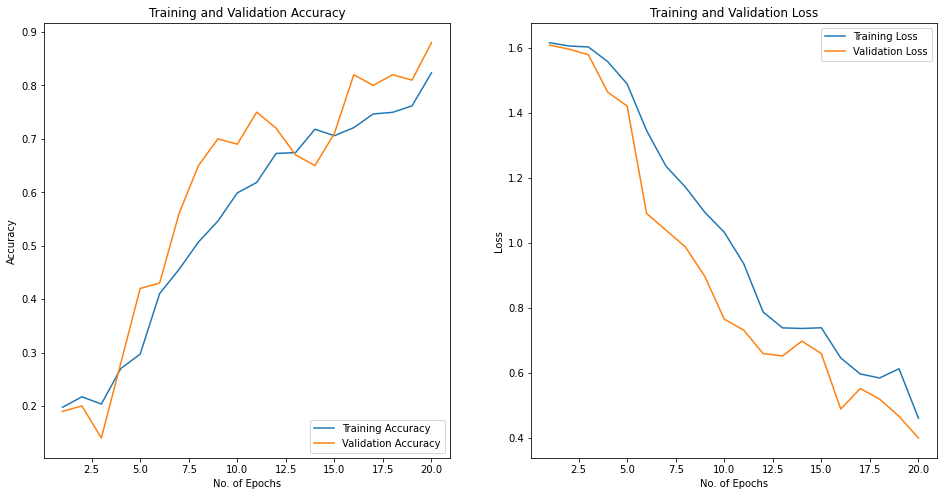

In [16]:
# Plotting results for model 4 after 20 epochs.
plot_results(history4, num_epochs)

In [17]:
num_epochs = 10
history4_part2 = train_model(model4, train_path, train_doc, val_path, val_doc, num_train_sequences, num_val_sequences, num_epochs, batch_size, num_frames, pref_shape)

Epoch 1/10
11/11 [==============================] - ETA: 0s - loss: 0.4386 - categorical_accuracy: 0.8235 
Epoch 00001: val_loss improved from inf to 0.47719, saving model to /home/dl_content/Upgrad_DL/Gesture_Recognition_Assignment/Models/model_init2021-09-2508_17_25.362934/model-00001-0.43857-0.82353-0.47719-0.83000.h5
11/11 [==============================] - 149s 14s/step - loss: 0.4386 - categorical_accuracy: 0.8235 - val_loss: 0.4772 - val_categorical_accuracy: 0.8300
Epoch 2/10
11/11 [==============================] - ETA: 0s - loss: 0.4128 - categorical_accuracy: 0.8416 
Epoch 00002: val_loss improved from 0.47719 to 0.34362, saving model to /home/dl_content/Upgrad_DL/Gesture_Recognition_Assignment/Models/model_init2021-09-2508_17_25.362934/model-00002-0.41277-0.84163-0.34362-0.86000.h5
11/11 [==============================] - 142s 13s/step - loss: 0.4128 - categorical_accuracy: 0.8416 - val_loss: 0.3436 - val_categorical_accuracy: 0.8600
Epoch 3/10
11/11 [======================

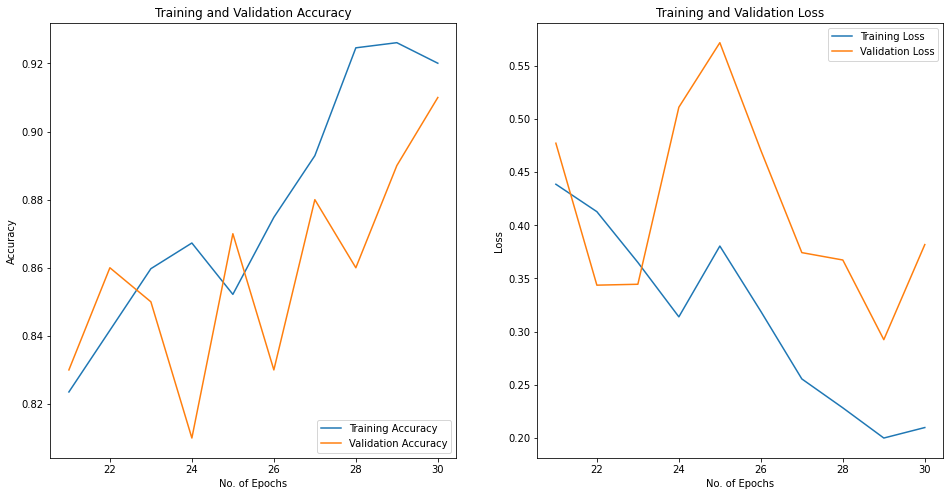

In [18]:
# Plot model 4 results - Epoch 21 to 30
  acc = history4_part2.history['categorical_accuracy']
  val_acc = history4_part2.history['val_categorical_accuracy']

  loss = history4_part2.history['loss']
  val_loss = history4_part2.history['val_loss']

  epochs_range = range(21,31)

  plt.figure(figsize=(16, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')
  plt.ylabel("Accuracy")
  plt.xlabel("No. of Epochs")

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.ylabel("Loss")
  plt.xlabel("No. of Epochs")

  plt.show()

#### Model 4 comments:
- Best metrics obtained:
    - Training Accuracy: 0.9261
    - Validation Accuracy: 0.8900
    - Training loss: 0.1998
    - Validation loss: 0.2923
    
- Reducing the number of parameters actually provides excellent results as compared to model 1. However, the training time is longer due to this model requiring more epochs to achieve similar results.
- Hence, we are probably better off continuing with the original architecture from model 1, which has provided with the best results thus far.

**---------------------------------------------------------------------------------------------------------------------------------------------------------**

### Model 5

- Reducing batch size to 32 and using the same architecture as model 1, which has been the best model so far.
- Architecture
    - 4 x Conv3D layers
    - 2 x Fully-connected layers (128 neurons each)
    - Output softmax layer
    - Activation function used: Relu
    - Optimizer: Adam (with default learning rate)
- Batch Size: 32
- No. of frames per sequence: 30
- Input image shape: (120,120,3)

In [13]:
# Defining hyperparameters for model 5
# Reducing the batch size.
batch_size = 32
print("Batch_size: ",batch_size)

num_frames = 30
print("# frames per sequence: ", num_frames)

pref_shape = (120, 120, 3)
print("Shape of all images: ", pref_shape)

# choose the number of epochs
num_epochs = 20
print ('# epochs =', num_epochs)

Batch_size:  32
# frames per sequence:  30
Shape of all images:  (120, 120, 3)
# epochs = 20


In [14]:
model5 = Sequential()

model5.add(Conv3D(16, kernel_size=(3,3,3), padding ='same', 
                  input_shape = (num_frames,pref_shape[0],pref_shape[1],pref_shape[2])))
model5.add(Activation('relu'))
model5.add(MaxPooling3D(pool_size=(2,2,2)))

model5.add(Conv3D(32, kernel_size=(3,3,3), padding ='same'))
model5.add(Activation('relu'))
model5.add(MaxPooling3D(pool_size=(2,2,2)))

model5.add(Conv3D(64, kernel_size=(3,3,3), padding ='same'))
model5.add(Activation('relu'))
model5.add(MaxPooling3D(pool_size=(2,2,2)))

model5.add(Conv3D(128, kernel_size=(3,3,3), padding ='same'))
model5.add(Activation('relu'))
model5.add(MaxPooling3D(pool_size=(2,2,2)))

model5.add(Flatten())
model5.add(Dense(128, activation = 'relu'))
model5.add(Dropout(0.3))

model5.add(Dense(128, activation = 'relu'))
model5.add(Dropout(0.3))

model5.add(Dense(num_classes, activation = 'softmax'))

optimiser = optimizers.Adam()
model5.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# View the summary of all layers
model5.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 30, 120, 120, 16)  1312      
_________________________________________________________________
activation (Activation)      (None, 30, 120, 120, 16)  0         
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 15, 60, 60, 16)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 15, 60, 60, 32)    13856     
_________________________________________________________________
activation_1 (Activation)    (None, 15, 60, 60, 32)    0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 7, 30, 30, 32)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 7, 30, 30, 64)     5

In [15]:
# Train the model
history5 = train_model(model5, train_path, train_doc, val_path, val_doc, num_train_sequences, num_val_sequences, num_epochs, batch_size, num_frames, pref_shape)

Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 1.6099 - categorical_accuracy: 0.2066
Epoch 00001: val_loss improved from inf to 1.57850, saving model to /home/dl_content/Upgrad_DL/Gesture_Recognition_Assignment/Models/model_init2021-09-2514_26_32.975273/model-00001-1.60992-0.20664-1.57850-0.11000.h5
21/21 [==============================] - 150s 7s/step - loss: 1.6099 - categorical_accuracy: 0.2066 - val_loss: 1.5785 - val_categorical_accuracy: 0.1100
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 1.5061 - categorical_accuracy: 0.2715
Epoch 00002: val_loss improved from 1.57850 to 1.31823, saving model to /home/dl_content/Upgrad_DL/Gesture_Recognition_Assignment/Models/model_init2021-09-2514_26_32.975273/model-00002-1.50609-0.27149-1.31823-0.52000.h5
21/21 [==============================] - 152s 7s/step - loss: 1.5061 - categorical_accuracy: 0.2715 - val_loss: 1.3182 - val_categorical_accuracy: 0.5200
Epoch 3/20
21/21 [==========================

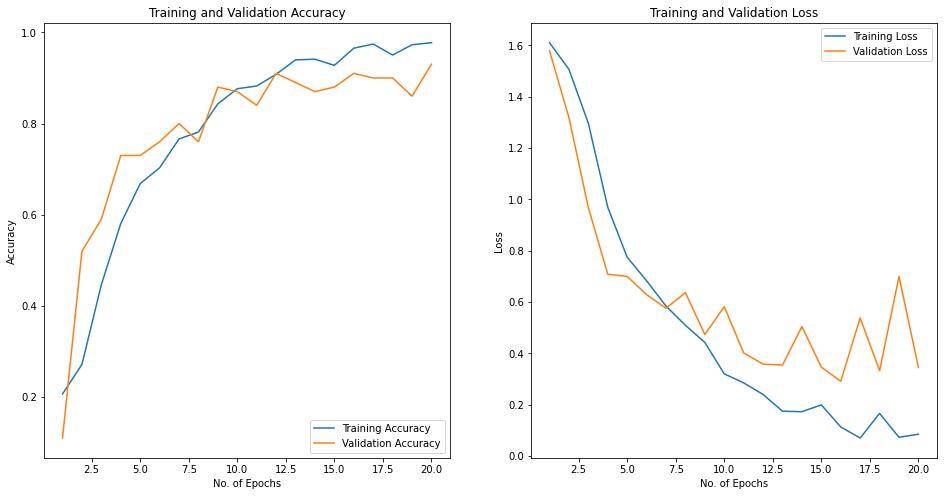

In [16]:
# Plotting results for model 5
plot_results(history5, num_epochs)

In [17]:
model5.save('/home/dl_content/Upgrad_DL/Gesture_Recognition_Assignment/Models/model-00020-0.0847-0.9774-0.3445-0.9300.h5')

In [18]:
model5.save_weights('/home/dl_content/Upgrad_DL/Gesture_Recognition_Assignment/Models/Model5_weights/')

#### Model 5 comments:
- Best metrics obtained:
    - Training Accuracy: 0.9774
    - Validation Accuracy: 0.9300
    - Training loss: 0.0847
    - Validation loss: 0.3445
    
- Reducing the batch size to 32 from 64 certainly helps quicken the training process up. High accuracies are obtained relatively quicker (in terms of no. of epochs) than earlier models.
- This may be attributed to the fact that with a smaller batch size, weight updates happen more often. This may call for using a batch size of 32 for future models as well.
- The results with a smaller batch size improve the results compared to our previous best model (Model 1).
- We shall consider Model 5 as our best model using Conv3D layers. Based on the results, this is certainly a very good model with little to no overfitting.

**---------------------------------------------------------------------------------------------------------------------------------------------------------**

## Conv2D + RNN models

- Let's now look at training some RNN models preceded by some Conv2D layers.
- The Conv2D layers would be responsible for feature extraction while the actual training for the sequences would be performed by RNN layers such as LSTM or GRU.

### Model 6 - Conv2D + LSTM

- Architecture
    - 4 x Conv2D layers
    - 1 x LSTM layer (Dropout: 0.3)
    - 1 x Fully-connected layers (Dropout: 0.3)
    - Output softmax layer
    - Activation function used: Relu
    - Optimizer: Adam (with default learning rate)
- Batch Size: 32
- No. of frames per sequence: 30
- Input image shape: (120,120,3)

In [13]:
# Defining hyperparameters
batch_size = 32
print("Batch_size: ",batch_size)

num_frames = 30
print("# frames per sequence: ", num_frames)

pref_shape = (120, 120, 3)
print("Shape of all images: ", pref_shape)

# choose the number of epochs
num_epochs = 20
print ('# epochs =', num_epochs)

Batch_size:  32
# frames per sequence:  30
Shape of all images:  (120, 120, 3)
# epochs = 20


In [14]:
model6 = Sequential()

model6.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(num_frames, pref_shape[0],pref_shape[1],pref_shape[2])))
model6.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model6.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model6.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model6.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model6.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model6.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model6.add(TimeDistributed(MaxPooling2D((2, 2))))
      
model6.add(TimeDistributed(Flatten()))

model6.add(LSTM(128))
model6.add(Dropout(0.3))
        
model6.add(Dense(128,activation='relu'))
model6.add(Dropout(0.3))
        
model6.add(Dense(num_classes, activation='softmax'))

optimiser = optimizers.Adam()
model6.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# View the summary of all layers
model6.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 30, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 30, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 30, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 30, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 30, 30, 30, 64)    18496     
_________________________________________________________________
time_distributed_5 (TimeDist (None, 30, 15, 15, 64)    0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 30, 15, 15, 128)   7

In [15]:
# Train the model
history6 = train_model(model6, train_path, train_doc, val_path, val_doc, num_train_sequences, num_val_sequences, num_epochs, batch_size, num_frames, pref_shape)

Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 1.6210 - categorical_accuracy: 0.2036
Epoch 00001: val_loss improved from inf to 1.56178, saving model to /home/dl_content/Upgrad_DL/Gesture_Recognition_Assignment/Models/model_init2021-09-2515_31_20.081520/model-00001-1.62097-0.20362-1.56178-0.21000.h5
21/21 [==============================] - 150s 7s/step - loss: 1.6210 - categorical_accuracy: 0.2036 - val_loss: 1.5618 - val_categorical_accuracy: 0.2100
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 1.4912 - categorical_accuracy: 0.3605
Epoch 00002: val_loss improved from 1.56178 to 1.32844, saving model to /home/dl_content/Upgrad_DL/Gesture_Recognition_Assignment/Models/model_init2021-09-2515_31_20.081520/model-00002-1.49117-0.36048-1.32844-0.40000.h5
21/21 [==============================] - 153s 7s/step - loss: 1.4912 - categorical_accuracy: 0.3605 - val_loss: 1.3284 - val_categorical_accuracy: 0.4000
Epoch 3/20
21/21 [==========================

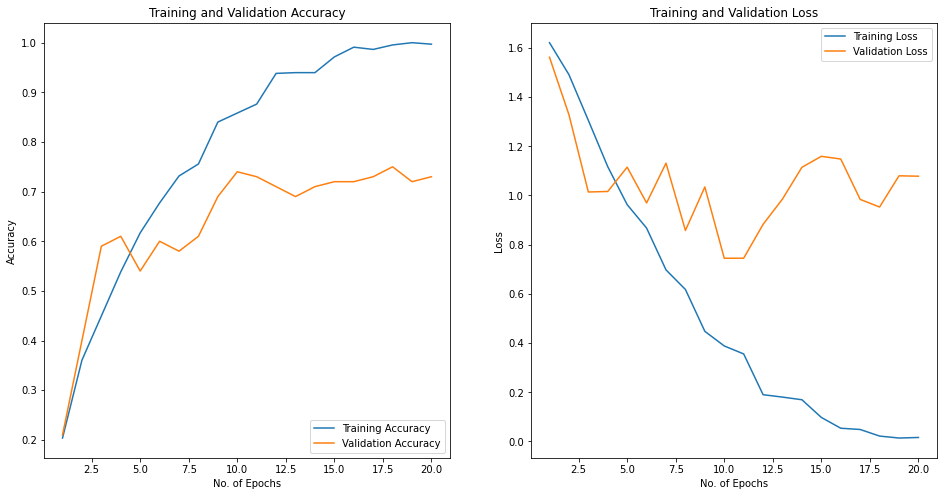

In [16]:
# Plotting results for model 6.
plot_results(history6, num_epochs)

#### Model 6 comments:
- Best metrics obtained:
    - Training Accuracy: 0.8582
    - Validation Accuracy: 0.7400
    - Training loss: 0.3882
    - Validation loss: 0.7448
    
- Definite overfitting observed for this model. More stringent regularization recommended.
- Training accuracy is almost 100% towards the latter epochs, while validation accuracy is languishing around 75%.

**---------------------------------------------------------------------------------------------------------------------------------------------------------**

### Model 7 

- More stringent regularization as compared to model 6. Dropout increased to 0.5
- Architecture
    - 4 x Conv2D layers
    - 1 x LSTM layer (Dropout: 0.5)
    - 1 x Fully-connected layers (Dropout: 0.5)
    - Output softmax layer
    - Activation function used: Relu
    - Optimizer: Adam (with default learning rate)
- Batch Size: 32
- No. of frames per sequence: 30
- Input image shape: (120,120,3)

In [13]:
# Defining hyperparameters
batch_size = 32
print("Batch_size: ",batch_size)

num_frames = 30
print("# frames per sequence: ", num_frames)

pref_shape = (120, 120, 3)
print("Shape of all images: ", pref_shape)

# choose the number of epochs
num_epochs = 20
print ('# epochs =', num_epochs)

Batch_size:  32
# frames per sequence:  30
Shape of all images:  (120, 120, 3)
# epochs = 20


In [14]:
model7 = Sequential()

model7.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(num_frames, pref_shape[0],pref_shape[1],pref_shape[2])))
model7.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model7.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model7.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model7.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model7.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model7.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model7.add(TimeDistributed(MaxPooling2D((2, 2))))
      
model7.add(TimeDistributed(Flatten()))

model7.add(LSTM(128))
model7.add(Dropout(0.5))
      
model7.add(Dense(128,activation='relu'))
model7.add(Dropout(0.5))
        
model7.add(Dense(num_classes, activation='softmax'))

optimiser = optimizers.Adam()
model7.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# View the summary of all layers
model7.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 30, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 30, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 30, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 30, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 30, 30, 30, 64)    18496     
_________________________________________________________________
time_distributed_5 (TimeDist (None, 30, 15, 15, 64)    0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 30, 15, 15, 128)   7

In [15]:
history7 = train_model(model7, train_path, train_doc, val_path, val_doc, num_train_sequences, num_val_sequences, num_epochs, batch_size, num_frames, pref_shape)

Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 1.6263 - categorical_accuracy: 0.1900
Epoch 00001: val_loss improved from inf to 1.59742, saving model to /home/dl_content/Upgrad_DL/Gesture_Recognition_Assignment/Models/model_init2021-09-2516_23_41.285197/model-00001-1.62630-0.19005-1.59742-0.18000.h5
21/21 [==============================] - 148s 7s/step - loss: 1.6263 - categorical_accuracy: 0.1900 - val_loss: 1.5974 - val_categorical_accuracy: 0.1800
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 1.5785 - categorical_accuracy: 0.2338
Epoch 00002: val_loss improved from 1.59742 to 1.49742, saving model to /home/dl_content/Upgrad_DL/Gesture_Recognition_Assignment/Models/model_init2021-09-2516_23_41.285197/model-00002-1.57853-0.23379-1.49742-0.35000.h5
21/21 [==============================] - 151s 7s/step - loss: 1.5785 - categorical_accuracy: 0.2338 - val_loss: 1.4974 - val_categorical_accuracy: 0.3500
Epoch 3/20
21/21 [==========================

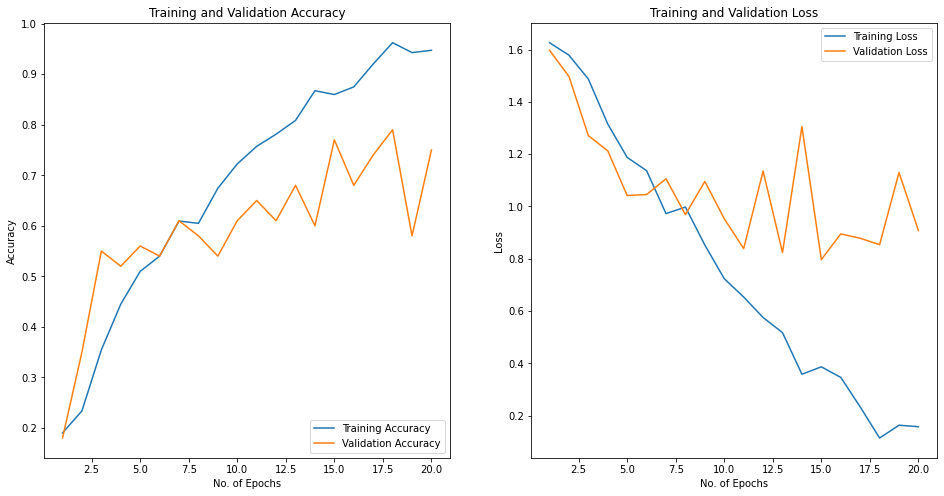

In [16]:
# Plotting results for model 7.
plot_results(history7, num_epochs)

#### Model 7 comments:
- Best metrics obtained:
    - Training Accuracy: 0.8597
    - Validation Accuracy: 0.7700
    - Training loss: 0.3866
    - Validation loss: 0.7971
    
- The overfitting seen in Model 6 has been reduced somewhat, but not significantly. This has come at the cost of reduced training accuracy values.
- Perhaps more regularization is required.

**---------------------------------------------------------------------------------------------------------------------------------------------------------**

### Model 8

- Adding dropout layers after each Conv2D layers on top of Model 7 architecture
- Architecture
    - 4 x Conv2D layers (Dropout of 0.25 after each Conv2D layer added)
    - 1 x LSTM layer (Dropout: 0.5)
    - 1 x Fully-connected layers (Dropout: 0.5)
    - Output softmax layer
    - Activation function used: Relu
    - Optimizer: Adam (Learning rate: 0.001)
- Batch Size: 32
- No. of frames per sequence: 30
- Input image shape: (120,120,3)

In [13]:
# Defining hyperparameters
batch_size = 32
print("Batch_size: ",batch_size)

num_frames = 30
print("# frames per sequence: ", num_frames)

pref_shape = (120, 120, 3)
print("Shape of all images: ", pref_shape)

# choose the number of epochs
num_epochs = 20
print ('# epochs =', num_epochs)

Batch_size:  32
# frames per sequence:  30
Shape of all images:  (120, 120, 3)
# epochs = 20


In [20]:
model8 = Sequential()

model8.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(num_frames, pref_shape[0],pref_shape[1],pref_shape[2])))
model8.add(TimeDistributed(MaxPooling2D((2, 2))))
model8.add(TimeDistributed(Dropout(0.25)))

model8.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model8.add(TimeDistributed(MaxPooling2D((2, 2))))
model8.add(TimeDistributed(Dropout(0.25)))

model8.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model8.add(TimeDistributed(MaxPooling2D((2, 2))))
model8.add(TimeDistributed(Dropout(0.25)))

model8.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model8.add(TimeDistributed(MaxPooling2D((2, 2))))
model8.add(TimeDistributed(Dropout(0.25)))

model8.add(TimeDistributed(Flatten()))

model8.add(LSTM(64))
model8.add(Dropout(0.5))

model8.add(Dense(128,activation='relu'))
model8.add(Dropout(0.5))
        
model8.add(Dense(num_classes, activation='softmax'))

optimiser = optimizers.Adam(0.001)
model8.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# View the summary of all layers
model8.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_45 (TimeDis (None, 30, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_46 (TimeDis (None, 30, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_47 (TimeDis (None, 30, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_48 (TimeDis (None, 30, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_49 (TimeDis (None, 30, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_50 (TimeDis (None, 30, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_51 (TimeDis (None, 30, 30, 30, 64)   

In [21]:
history8 = train_model(model8, train_path, train_doc, val_path, val_doc, num_train_sequences, num_val_sequences, num_epochs, batch_size, num_frames, pref_shape)

Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 1.6719 - categorical_accuracy: 0.2066
Epoch 00001: val_loss improved from inf to 1.60808, saving model to /home/dl_content/Upgrad_DL/Gesture_Recognition_Assignment/Models/model_init2021-09-2517_17_57.744056/model-00001-1.67189-0.20664-1.60808-0.29000.h5
21/21 [==============================] - 148s 7s/step - loss: 1.6719 - categorical_accuracy: 0.2066 - val_loss: 1.6081 - val_categorical_accuracy: 0.2900
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 1.6140 - categorical_accuracy: 0.1750
Epoch 00002: val_loss did not improve from 1.60808
21/21 [==============================] - 151s 7s/step - loss: 1.6140 - categorical_accuracy: 0.1750 - val_loss: 1.6087 - val_categorical_accuracy: 0.1900
Epoch 3/20
21/21 [==============================] - ETA: 0s - loss: 1.6015 - categorical_accuracy: 0.2127
Epoch 00003: val_loss improved from 1.60808 to 1.59298, saving model to /home/dl_content/Upgrad_DL/Gesture_

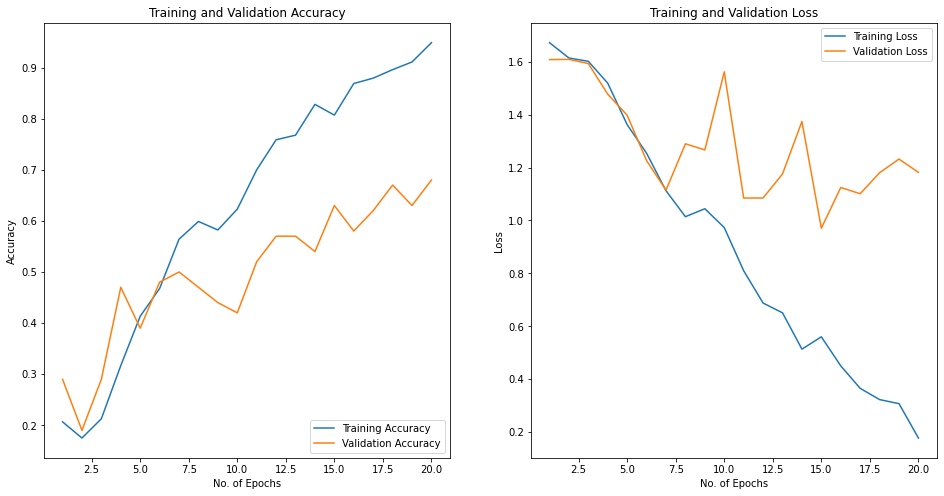

In [22]:
# Plotting results for model 8.
plot_results(history8, num_epochs)

#### Model 8 comments:
- Best metrics obtained:
    - Training Accuracy: 0.8069
    - Validation Accuracy: 0.6300
    - Training loss: 0.5600
    - Validation loss: 0.9706
    
- Model is clearly still overfitting. Adding dropout layers after Conv2D layers does not seem to have helped in any way.

**---------------------------------------------------------------------------------------------------------------------------------------------------------**
    

### Model 9 - Conv2D + GRU

- Replacing the LSTM layer with GRU layer to see how this performs.
- Architecture
    - 4 x Conv2D layers 
    - 1 x GRU layer (Dropout: 0.5)
    - 1 x Fully-connected layers (Dropout: 0.5)
    - Output softmax layer
    - Activation function: relu
    - Optimizer: Adam (Reduced Learning rate: 0.0001)
- Batch Size: 32
- No. of frames per sequence: 30
- Input image shape: (120,120,3)

In [13]:
# Defining hyperparameters
batch_size = 32
print("Batch_size: ",batch_size)

num_frames = 30
print("# frames per sequence: ", num_frames)

pref_shape = (120, 120, 3)
print("Shape of all images: ", pref_shape)

# choose the number of epochs
num_epochs = 20
print ('# epochs =', num_epochs)

Batch_size:  32
# frames per sequence:  30
Shape of all images:  (120, 120, 3)
# epochs = 20


In [14]:
model9 = Sequential()

model9.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(num_frames, pref_shape[0],pref_shape[1],pref_shape[2])))
model9.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model9.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model9.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model9.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model9.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model9.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model9.add(TimeDistributed(MaxPooling2D((2, 2))))
      
model9.add(TimeDistributed(Flatten()))

model9.add(GRU(128))
model9.add(Dropout(0.5))
        
model9.add(Dense(128,activation='relu'))
model9.add(Dropout(0.5))
        
model9.add(Dense(num_classes, activation='softmax'))

optimiser = optimizers.Adam(0.0001)
model9.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# View the summary of all layers
model9.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 30, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 30, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 30, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 30, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 30, 30, 30, 64)    18496     
_________________________________________________________________
time_distributed_5 (TimeDist (None, 30, 15, 15, 64)    0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 30, 15, 15, 128)   7

In [15]:
history9 = train_model(model9, train_path, train_doc, val_path, val_doc, num_train_sequences, num_val_sequences, num_epochs, batch_size, num_frames, pref_shape)

Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 1.6076 - categorical_accuracy: 0.2036
Epoch 00001: val_loss improved from inf to 1.60258, saving model to /home/dl_content/Upgrad_DL/Gesture_Recognition_Assignment/Models/model_init2021-09-2610_41_35.376586/model-00001-1.60758-0.20362-1.60258-0.22000.h5
21/21 [==============================] - 148s 7s/step - loss: 1.6076 - categorical_accuracy: 0.2036 - val_loss: 1.6026 - val_categorical_accuracy: 0.2200
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 1.5969 - categorical_accuracy: 0.2217
Epoch 00002: val_loss improved from 1.60258 to 1.58869, saving model to /home/dl_content/Upgrad_DL/Gesture_Recognition_Assignment/Models/model_init2021-09-2610_41_35.376586/model-00002-1.59688-0.22172-1.58869-0.19000.h5
21/21 [==============================] - 153s 7s/step - loss: 1.5969 - categorical_accuracy: 0.2217 - val_loss: 1.5887 - val_categorical_accuracy: 0.1900
Epoch 3/20
21/21 [==========================

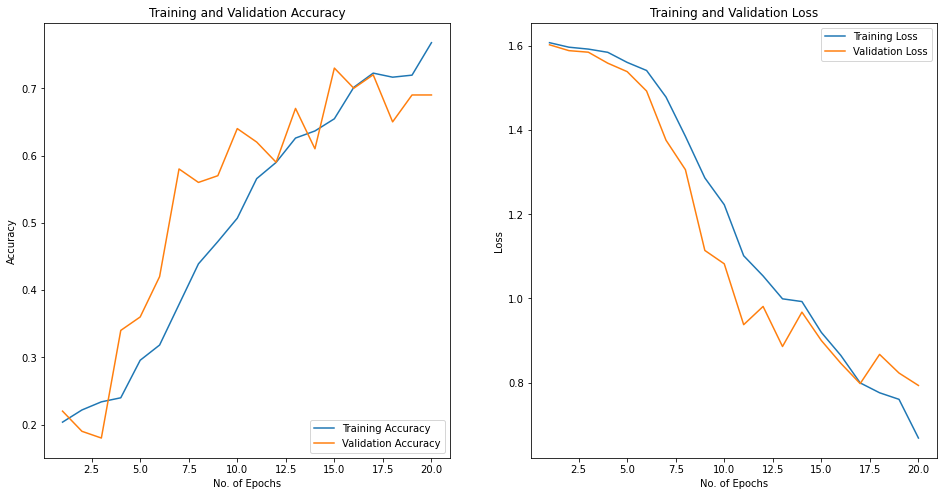

In [16]:
# Plotting results for model 9.
plot_results(history9, num_epochs)

In [17]:
# Training model 9 for another 10 epochs
history9_part2 = train_model(model9, train_path, train_doc, val_path, val_doc, num_train_sequences, num_val_sequences, 10, batch_size, num_frames, pref_shape)

Epoch 1/10
21/21 [==============================] - ETA: 0s - loss: 0.6202 - categorical_accuracy: 0.7662
Epoch 00001: val_loss improved from inf to 0.77301, saving model to /home/dl_content/Upgrad_DL/Gesture_Recognition_Assignment/Models/model_init2021-09-2611_31_49.110117/model-00001-0.62017-0.76621-0.77301-0.70000.h5
21/21 [==============================] - 150s 7s/step - loss: 0.6202 - categorical_accuracy: 0.7662 - val_loss: 0.7730 - val_categorical_accuracy: 0.7000
Epoch 2/10
21/21 [==============================] - ETA: 0s - loss: 0.5542 - categorical_accuracy: 0.8084
Epoch 00002: val_loss did not improve from 0.77301
21/21 [==============================] - 149s 7s/step - loss: 0.5542 - categorical_accuracy: 0.8084 - val_loss: 0.8441 - val_categorical_accuracy: 0.6700
Epoch 3/10
21/21 [==============================] - ETA: 0s - loss: 0.5709 - categorical_accuracy: 0.8115
Epoch 00003: val_loss improved from 0.77301 to 0.69725, saving model to /home/dl_content/Upgrad_DL/Gesture_

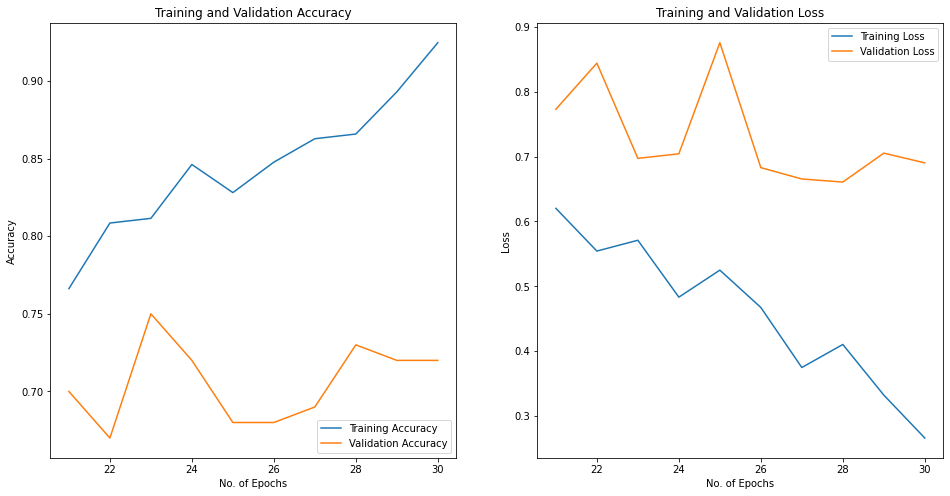

In [18]:
# Plot model 9 results - Epoch 21 to 30
  acc = history9_part2.history['categorical_accuracy']
  val_acc = history9_part2.history['val_categorical_accuracy']

  loss = history9_part2.history['loss']
  val_loss = history9_part2.history['val_loss']

  epochs_range = range(21,31)

  plt.figure(figsize=(16, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')
  plt.ylabel("Accuracy")
  plt.xlabel("No. of Epochs")

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.ylabel("Loss")
  plt.xlabel("No. of Epochs")

  plt.show()

#### Model 9 comments:
- Best metrics obtained:
    - Training Accuracy: 0.8658
    - Validation Accuracy: 0.7300
    - Training loss: 0.4102
    - Validation loss: 0.6607
    
- As with the LSTM models, there is still overfitting observed.
- Reducing the learning rate results in slower training, but is relatively more stable.


**---------------------------------------------------------------------------------------------------------------------------------------------------------**

### Model 10

- Reducing the number of neurons in GRU and the fully-connected layers.
- Architecture
    - 4 x Conv2D layers 
    - 1 x GRU layer (64 GRU cells, Dropout: 0.5)
    - 1 x Fully-connected layers (64 dense neurons, Dropout: 0.5)
    - Output softmax layer
    - Activation function: relu
    - Optimizer: Adam (Learning rate: 0.0003)
- Batch Size: 32
- No. of frames per sequence: 30
- Input image shape: (120,120,3)

In [13]:
# Defining hyperparameters
batch_size = 32
print("Batch_size: ",batch_size)

num_frames = 30
print("# frames per sequence: ", num_frames)

pref_shape = (120, 120, 3)
print("Shape of all images: ", pref_shape)

# choose the number of epochs
num_epochs = 20
print ('# epochs =', num_epochs)

Batch_size:  32
# frames per sequence:  30
Shape of all images:  (120, 120, 3)
# epochs = 20


In [15]:
model10 = Sequential()

model10.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(num_frames, pref_shape[0],pref_shape[1],pref_shape[2])))
model10.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model10.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model10.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model10.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model10.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model10.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model10.add(TimeDistributed(MaxPooling2D((2, 2))))
      
model10.add(TimeDistributed(Flatten()))

model10.add(GRU(64))
model10.add(Dropout(0.5))
        
model10.add(Dense(64,activation='relu'))
model10.add(Dropout(0.5))
        
model10.add(Dense(num_classes, activation='softmax'))
optimiser = optimizers.Adam(0.0003)
model10.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# View the summary of all layers
model10.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_9 (TimeDist (None, 30, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_10 (TimeDis (None, 30, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_11 (TimeDis (None, 30, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_12 (TimeDis (None, 30, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_13 (TimeDis (None, 30, 30, 30, 64)    18496     
_________________________________________________________________
time_distributed_14 (TimeDis (None, 30, 15, 15, 64)    0         
_________________________________________________________________
time_distributed_15 (TimeDis (None, 30, 15, 15, 128)  

In [16]:
# Train the model
history10 = train_model(model10, train_path, train_doc, val_path, val_doc, num_train_sequences, num_val_sequences, num_epochs, batch_size, num_frames, pref_shape)

Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 1.6182 - categorical_accuracy: 0.1900
Epoch 00001: val_loss improved from inf to 1.59577, saving model to /home/dl_content/Upgrad_DL/Gesture_Recognition_Assignment/Models/model_init2021-09-2611_58_30.913983/model-00001-1.61819-0.19005-1.59577-0.21000.h5
21/21 [==============================] - 148s 7s/step - loss: 1.6182 - categorical_accuracy: 0.1900 - val_loss: 1.5958 - val_categorical_accuracy: 0.2100
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 1.5884 - categorical_accuracy: 0.2278
Epoch 00002: val_loss improved from 1.59577 to 1.58441, saving model to /home/dl_content/Upgrad_DL/Gesture_Recognition_Assignment/Models/model_init2021-09-2611_58_30.913983/model-00002-1.58841-0.22775-1.58441-0.19000.h5
21/21 [==============================] - 152s 7s/step - loss: 1.5884 - categorical_accuracy: 0.2278 - val_loss: 1.5844 - val_categorical_accuracy: 0.1900
Epoch 3/20
21/21 [==========================

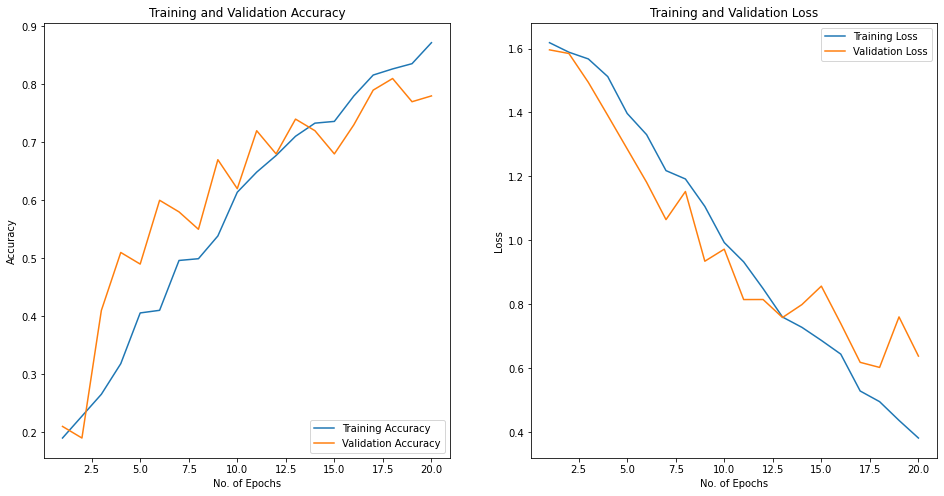

In [17]:
# Plotting results for model 10.
plot_results(history10, num_epochs)

In [18]:
history10_part2 = train_model(model10, train_path, train_doc, val_path, val_doc, num_train_sequences, num_val_sequences, 10, batch_size, num_frames, pref_shape)

Epoch 1/10
21/21 [==============================] - ETA: 0s - loss: 0.2939 - categorical_accuracy: 0.9080
Epoch 00001: val_loss improved from inf to 0.68014, saving model to /home/dl_content/Upgrad_DL/Gesture_Recognition_Assignment/Models/model_init2021-09-2612_48_42.959184/model-00001-0.29390-0.90799-0.68014-0.79000.h5
21/21 [==============================] - 151s 7s/step - loss: 0.2939 - categorical_accuracy: 0.9080 - val_loss: 0.6801 - val_categorical_accuracy: 0.7900
Epoch 2/10
21/21 [==============================] - ETA: 0s - loss: 0.2537 - categorical_accuracy: 0.9170
Epoch 00002: val_loss improved from 0.68014 to 0.62394, saving model to /home/dl_content/Upgrad_DL/Gesture_Recognition_Assignment/Models/model_init2021-09-2612_48_42.959184/model-00002-0.25371-0.91704-0.62394-0.80000.h5
21/21 [==============================] - 149s 7s/step - loss: 0.2537 - categorical_accuracy: 0.9170 - val_loss: 0.6239 - val_categorical_accuracy: 0.8000
Epoch 3/10
21/21 [==========================

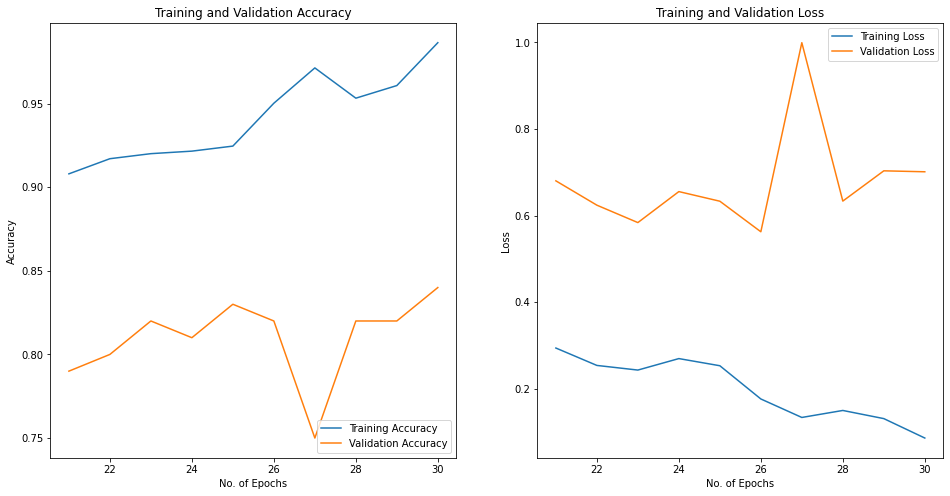

In [19]:
# Plot model 10 results - Epoch 21 to 30
  acc = history10_part2.history['categorical_accuracy']
  val_acc = history10_part2.history['val_categorical_accuracy']

  loss = history10_part2.history['loss']
  val_loss = history10_part2.history['val_loss']

  epochs_range = range(21,31)

  plt.figure(figsize=(16, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')
  plt.ylabel("Accuracy")
  plt.xlabel("No. of Epochs")

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.ylabel("Loss")
  plt.xlabel("No. of Epochs")

  plt.show()

#### Model 10 comments
- Best metrics obtained:
    - Training Accuracy: 0.9246
    - Validation Accuracy: 0.8200
    - Training loss: 0.1762
    - Validation loss: 0.5625
    
- Results don't seem to improve in any way by reducing the network width.
- Overfitting is still an issue.

**---------------------------------------------------------------------------------------------------------------------------------------------------------**

### Model 11
- Adding an additional GRU layer, but reducing the no. of cells in each GRU layer to 64.
- Architecture
    - 4 x Conv2D layers 
    - 1 x GRU layer (64 GRU cells, Dropout: 0.3)
    - 1 x Fully-connected layers (64 dense neurons, Dropout: 0.4)
    - Output softmax layer
    - Activation function: relu
    - Optimizer: Adam (Learning rate: 0.0003)
- Batch Size: 32
- No. of frames per sequence: 30
- Input image shape: (120,120,3)

In [13]:
# Defining hyperparameters
batch_size = 32
print("Batch_size: ",batch_size)

num_frames = 30
print("# frames per sequence: ", num_frames)

pref_shape = (120, 120, 3)
print("Shape of all images: ", pref_shape)

# choose the number of epochs
num_epochs = 20
print ('# epochs =', num_epochs)

Batch_size:  32
# frames per sequence:  30
Shape of all images:  (120, 120, 3)
# epochs = 20


In [14]:
model11 = Sequential()

model11.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(num_frames, pref_shape[0],pref_shape[1],pref_shape[2])))
model11.add(TimeDistributed(MaxPooling2D((2, 2))))

model11.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model11.add(TimeDistributed(MaxPooling2D((2, 2))))

model11.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model11.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model11.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model11.add(TimeDistributed(MaxPooling2D((2, 2))))
      
model11.add(TimeDistributed(Flatten()))

model11.add(GRU(64, return_sequences=True))
model11.add(Dropout(0.3))

model11.add(GRU(64))
model11.add(Dropout(0.3))
        
model11.add(Dense(64,activation='relu'))
model11.add(Dropout(0.4))
       
model11.add(Dense(num_classes, activation='softmax'))
optimiser = optimizers.Adam()
model11.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# View the summary of all layers
model11.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 30, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 30, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 30, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 30, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 30, 30, 30, 64)    18496     
_________________________________________________________________
time_distributed_5 (TimeDist (None, 30, 15, 15, 64)    0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 30, 15, 15, 128)   7

In [15]:
# Train the model
history11 = train_model(model11, train_path, train_doc, val_path, val_doc, num_train_sequences, num_val_sequences, num_epochs, batch_size, num_frames, pref_shape)

Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 1.6156 - categorical_accuracy: 0.2021
Epoch 00001: val_loss improved from inf to 1.59775, saving model to /home/dl_content/Upgrad_DL/Gesture_Recognition_Assignment/Models/model_init2021-09-2614_41_31.799222/model-00001-1.61564-0.20211-1.59775-0.21000.h5
21/21 [==============================] - 148s 7s/step - loss: 1.6156 - categorical_accuracy: 0.2021 - val_loss: 1.5978 - val_categorical_accuracy: 0.2100
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 1.5773 - categorical_accuracy: 0.2549
Epoch 00002: val_loss improved from 1.59775 to 1.45415, saving model to /home/dl_content/Upgrad_DL/Gesture_Recognition_Assignment/Models/model_init2021-09-2614_41_31.799222/model-00002-1.57732-0.25490-1.45415-0.30000.h5
21/21 [==============================] - 154s 7s/step - loss: 1.5773 - categorical_accuracy: 0.2549 - val_loss: 1.4541 - val_categorical_accuracy: 0.3000
Epoch 3/20
21/21 [==========================

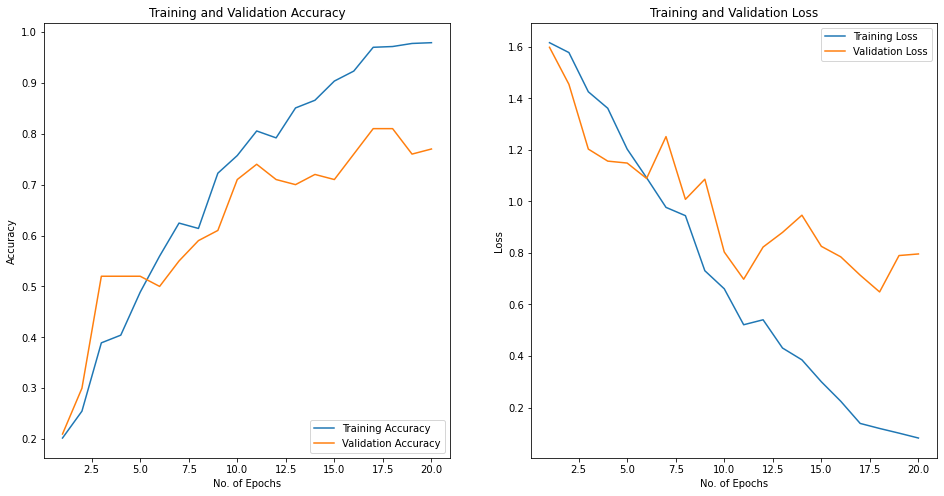

In [16]:
# Plotting results for model 11.
plot_results(history11, num_epochs)

#### Model 11 comments
- Best metrics obtained:
    - Training Accuracy: 0.9713
    - Validation Accuracy: 0.8100
    - Training loss: 0.1189
    - Validation loss: 0.6486
    
- Overfitting does not seem to be resolved in any of the models despite achieving very high training accuracies and relatively high validation accuracies.
- It may be due to feature extraction in the Conv2D layers being inadequate. Applying transfer learning with some pre-defined models may be suitable.

**---------------------------------------------------------------------------------------------------------------------------------------------------------**

## Transfer Learning + RNN models

- We are going to use MobileNetV2 for our transfer learning since it is relatively light-weight. Paper: https://arxiv.org/pdf/1801.04381v4.pdf

- MobileNetV2 is a convolutional neural network architecture that seeks to perform well on mobile devices. It is based on an inverted residual structure where the residual connections are between the bottleneck layers.

### Model 12 - Transfer Learning + GRU

- Using mobilenet v2 as our pre-defined model since it is a relatively light weight model.
- Including both the architecture as well as the weights from the pre-defined model. This would keep the number of trainable parameters relatively low.
- Architecture
    - Pre-defined Conv2D model: Mobilenet V2 (Architecture and weights)
    - 1 x GRU layer: 128 GRU cells, Dropout: 0.4
    - 1 x Fully-connected layer: 128 Dense neurons,Dropout: 0.4, Activation fn: relu
    - Output softmax layer
    - Optimizer: Adam (with default learning rate)
- Batch Size: 32
- No. of frames per sequence: 30
- Input image shape: (120,120,3)

In [13]:
# Defining hyperparameters
batch_size = 32
print("Batch_size: ",batch_size)

num_frames = 30
print("# frames per sequence: ", num_frames)

pref_shape = (120, 120, 3)
print("Shape of all images: ", pref_shape)

# choose the number of epochs
num_epochs = 15
print ('# epochs =', num_epochs)

Batch_size:  32
# frames per sequence:  30
Shape of all images:  (120, 120, 3)
# epochs = 15


In [14]:
mobilenet = tf.keras.applications.MobileNetV2(include_top=False, weights='imagenet', input_shape=(pref_shape[0],pref_shape[1],pref_shape[2]))

model12 = Sequential()
model12.add(TimeDistributed(mobilenet, input_shape=(num_frames, pref_shape[0],pref_shape[1],pref_shape[2])))

for layer in model12.layers:
    layer.trainable = False

#model12.add(TimeDistributed(GlobalAveragePooling2D()))
model12.add(TimeDistributed(MaxPooling2D(2,2)))
model12.add(TimeDistributed(Flatten()))

model12.add(GRU(128))
model12.add(Dropout(0.4))
        
model12.add(Dense(128,activation='relu'))
model12.add(Dropout(0.4))
       
model12.add(Dense(num_classes, activation='softmax'))

optimiser = optimizers.Adam()
model12.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Let's take a look at the base model architecture
model12.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 30, 4, 4, 1280)    2257984   
_________________________________________________________________
time_distributed_1 (TimeDist (None, 30, 2, 2, 1280)    0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 30, 5120)          0         
_________________________________________________________________
gru (GRU)                    (None, 128)               2016000   
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

In [15]:
history12 = train_model(model12, train_path, train_doc, val_path, val_doc, num_train_sequences, num_val_sequences, num_epochs, batch_size, num_frames, pref_shape)

Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 1.7700 - categorical_accuracy: 0.2549
Epoch 00001: val_loss improved from inf to 1.26787, saving model to /home/dl_content/Upgrad_DL/Gesture_Recognition_Assignment/Models/model_init2021-09-2605_03_48.290727/model-00001-1.77003-0.25490-1.26787-0.50000.h5
21/21 [==============================] - 148s 7s/step - loss: 1.7700 - categorical_accuracy: 0.2549 - val_loss: 1.2679 - val_categorical_accuracy: 0.5000
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 1.3195 - categorical_accuracy: 0.4706
Epoch 00002: val_loss improved from 1.26787 to 1.02524, saving model to /home/dl_content/Upgrad_DL/Gesture_Recognition_Assignment/Models/model_init2021-09-2605_03_48.290727/model-00002-1.31951-0.47059-1.02524-0.59000.h5
21/21 [==============================] - 150s 7s/step - loss: 1.3195 - categorical_accuracy: 0.4706 - val_loss: 1.0252 - val_categorical_accuracy: 0.5900
Epoch 3/20
21/21 [==========================

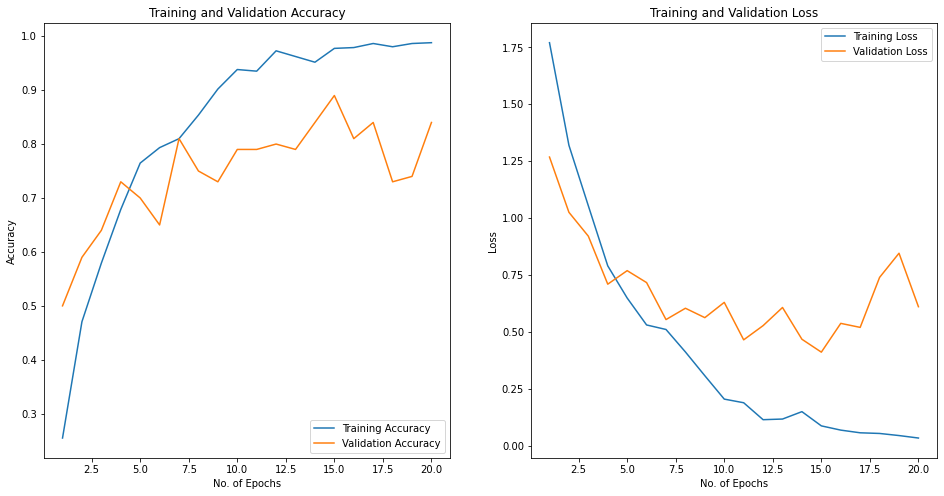

In [16]:
# Plotting results for model 12.
plot_results(history12, num_epochs)

#### Model 12 comments:
- Best metrics obtained:
    - Training Accuracy: 0.9774
    - Validation Accuracy: 0.8900
    - Training loss: 0.0875
    - Validation loss: 0.4112

- The weights from the pre-defined model do a good job in ramping up training accuracy fairly quickly. This indicates that the pre-defined model is able to extract features decently.
- However, after keeping up with training accuracy for a while, the validation accuracy stagnates around 85%.
- There is some overfitting which needs to be addressed, potentially by only importing the architecture from the pre-defined model and re-training the weights.
- The less than optimal results may have been because the pre-defined model was trained on different images with different input shapes.

**---------------------------------------------------------------------------------------------------------------------------------------------------------**

### Model 13
- Using mobilenet v2 as our pre-defined model, but re-training the weights using our dataset. 
- Including only the architecture from the pre-defined model. 
- Architecture
    - Pre-defined Conv2D model: Mobilenet V2 (Re-training the weights)
    - 1 x GRU layer: 128 GRU cells, Dropout: 0.5
    - 1 x Fully-connected layer: 128 Dense neurons,Dropout: 0.5, Activation fn: relu
    - Output softmax layer
    - Optimizer: Adam (Learning rate: 0.0003)
- Batch Size: 32 ( failed). Changed to 16 in Attempt 2
- No. of frames per sequence: 30
- Input image shape: (120,120,3)

In [13]:
# Defining hyperparameters
# Batch size reduced to 16 after initial attempt at running this model with batch size of 32 failed. (See errors below)
batch_size = 16
print("Batch_size: ",batch_size)

num_frames = 30
print("# frames per sequence: ", num_frames)

pref_shape = (120, 120, 3)
print("Shape of all images: ", pref_shape)

# choose the number of epochs
num_epochs = 20
print ('# epochs =', num_epochs)

Batch_size:  16
# frames per sequence:  30
Shape of all images:  (120, 120, 3)
# epochs = 20


In [14]:
mobilenet = tf.keras.applications.MobileNetV2(include_top=False, weights='imagenet', input_shape=(pref_shape[0],pref_shape[1],pref_shape[2]))

model13 = Sequential()
model13.add(TimeDistributed(mobilenet, input_shape=(num_frames, pref_shape[0],pref_shape[1],pref_shape[2])))

#for layer in model12.layers:
#    layer.trainable = False

model13.add(TimeDistributed(MaxPooling2D(2,2)))
model13.add(TimeDistributed(Flatten()))

model13.add(GRU(128))
model13.add(Dropout(0.5))
        
model13.add(Dense(128,activation='relu'))
model13.add(Dropout(0.5))
       
model13.add(Dense(num_classes, activation='softmax'))

optimiser = optimizers.Adam(0.0003)
model13.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Let's take a look at the base model architecture
model13.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 30, 4, 4, 1280)    2257984   
_________________________________________________________________
time_distributed_1 (TimeDist (None, 30, 2, 2, 1280)    0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 30, 5120)          0         
_________________________________________________________________
gru (GRU)                    (None, 128)               2016000   
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

In [17]:
# Train the model
history13 = train_model(model13, train_path, train_doc, val_path, val_doc, num_train_sequences, num_val_sequences, num_epochs, batch_size, num_frames, pref_shape)

Epoch 1/20


ResourceExhaustedError:  OOM when allocating tensor with shape[960,576,8,8] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node sequential_2/time_distributed_6/mobilenetv2_1.00_224/block_11_expand/Conv2D (defined at <ipython-input-10-73333e86258e>:31) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_40878]

Function call stack:
train_function


In [15]:
# Attempt 2 at training the model with a lower batch size of 16
history13 = train_model(model13, train_path, train_doc, val_path, val_doc, num_train_sequences, num_val_sequences, num_epochs, batch_size, num_frames, pref_shape)

Epoch 1/20
42/42 [==============================] - ETA: 0s - loss: 1.9025 - categorical_accuracy: 0.2474
Epoch 00001: val_loss improved from inf to 1.42873, saving model to /home/dl_content/Upgrad_DL/Gesture_Recognition_Assignment/Models/model_init2021-09-2705_08_02.389456/model-00001-1.90247-0.24736-1.42873-0.46000.h5
42/42 [==============================] - 152s 4s/step - loss: 1.9025 - categorical_accuracy: 0.2474 - val_loss: 1.4287 - val_categorical_accuracy: 0.4600
Epoch 2/20
42/42 [==============================] - ETA: 0s - loss: 1.3999 - categorical_accuracy: 0.4359
Epoch 00002: val_loss improved from 1.42873 to 1.20979, saving model to /home/dl_content/Upgrad_DL/Gesture_Recognition_Assignment/Models/model_init2021-09-2705_08_02.389456/model-00002-1.39989-0.43590-1.20979-0.50000.h5
42/42 [==============================] - 153s 4s/step - loss: 1.3999 - categorical_accuracy: 0.4359 - val_loss: 1.2098 - val_categorical_accuracy: 0.5000
Epoch 3/20
42/42 [==========================

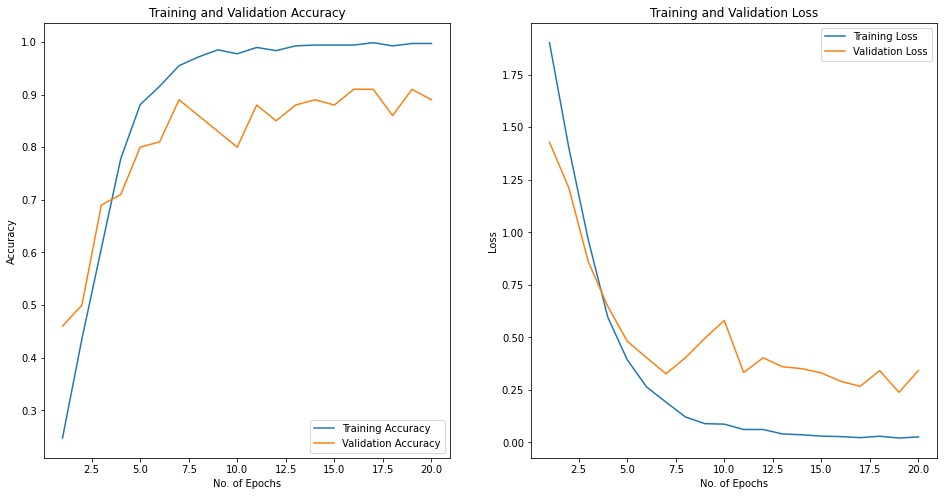

In [16]:
# Plotting results for model 13.
plot_results(history13, num_epochs)

#### Model 13 comments:
- Best metrics obtained:
    - Training Accuracy: 0.9970
    - Validation Accuracy: 0.9100
    - Training loss: 0.0201
    - Validation loss: 0.2378
    
- The results are quite promising, but there is a little bit of overfitting still present.
- The validation accuracy plateaus out at about 91%, while training accuracy is up at 99%.
- Possible remedies may be to 
    - Increase regularization
    - Increase network width
    - Reducing the learning rate further.-

**---------------------------------------------------------------------------------------------------------------------------------------------------------**

### Model 14
- Using mobilenet v2 as our pre-defined model, but re-training the weights using our dataset. 
- Changes from model 13:
    - Increasing the width of the fully-connected layer to 256
    - Decreasing the learning rate further to 0.0001
- Architecture
    - Pre-defined Conv2D model: Mobilenet V2 (Re-training the weights)
    - 1 x GRU layer: 128 GRU cells, Dropout: 0.5
    - 1 x Fully-connected layer: 128 Dense neurons,Dropout: 0.5, Activation fn: relu
    - Output softmax layer
    - Optimizer: Adam (Learning rate: 0.0003)
- Batch Size: 16
- No. of frames per sequence: 30
- Input image shape: (120,120,3)

In [13]:
# Defining hyperparameters for model 4
batch_size = 16
print("Batch_size: ",batch_size)

num_frames = 30
print("# frames per sequence: ", num_frames)

pref_shape = (120, 120, 3)
print("Shape of all images: ", pref_shape)

# choose the number of epochs
num_epochs = 20
print ('# epochs =', num_epochs)

Batch_size:  16
# frames per sequence:  30
Shape of all images:  (120, 120, 3)
# epochs = 20


In [14]:
mobilenet = tf.keras.applications.MobileNetV2(include_top=False, weights='imagenet', input_shape=(pref_shape[0],pref_shape[1],pref_shape[2]))

model14 = Sequential()
model14.add(TimeDistributed(mobilenet, input_shape=(num_frames, pref_shape[0],pref_shape[1],pref_shape[2])))

model14.add(TimeDistributed(MaxPooling2D(2,2)))
model14.add(TimeDistributed(Flatten()))

model14.add(GRU(128))
model14.add(Dropout(0.5))
        
model14.add(Dense(256,activation='relu'))
model14.add(Dropout(0.5))
       
model14.add(Dense(num_classes, activation='softmax'))

optimiser = optimizers.Adam(0.0001)
model14.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Let's take a look at the base model architecture
model14.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 30, 4, 4, 1280)    2257984   
_________________________________________________________________
time_distributed_1 (TimeDist (None, 30, 2, 2, 1280)    0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 30, 5120)          0         
_________________________________________________________________
gru (GRU)                    (None, 128)               2016000   
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0

In [15]:
# Train the model
history14 = train_model(model14, train_path, train_doc, val_path, val_doc, num_train_sequences, num_val_sequences, num_epochs, batch_size, num_frames, pref_shape)

Epoch 1/20
42/42 [==============================] - ETA: 0s - loss: 1.8993 - categorical_accuracy: 0.2323
Epoch 00001: val_loss improved from inf to 1.50843, saving model to /home/dl_content/Upgrad_DL/Gesture_Recognition_Assignment/Models/model_init2021-09-2705_59_36.887904/model-00001-1.89933-0.23228-1.50843-0.28000.h5
42/42 [==============================] - 149s 4s/step - loss: 1.8993 - categorical_accuracy: 0.2323 - val_loss: 1.5084 - val_categorical_accuracy: 0.2800
Epoch 2/20
42/42 [==============================] - ETA: 0s - loss: 1.5134 - categorical_accuracy: 0.3665
Epoch 00002: val_loss improved from 1.50843 to 1.39629, saving model to /home/dl_content/Upgrad_DL/Gesture_Recognition_Assignment/Models/model_init2021-09-2705_59_36.887904/model-00002-1.51343-0.36652-1.39629-0.38000.h5
42/42 [==============================] - 150s 4s/step - loss: 1.5134 - categorical_accuracy: 0.3665 - val_loss: 1.3963 - val_categorical_accuracy: 0.3800
Epoch 3/20
42/42 [==========================

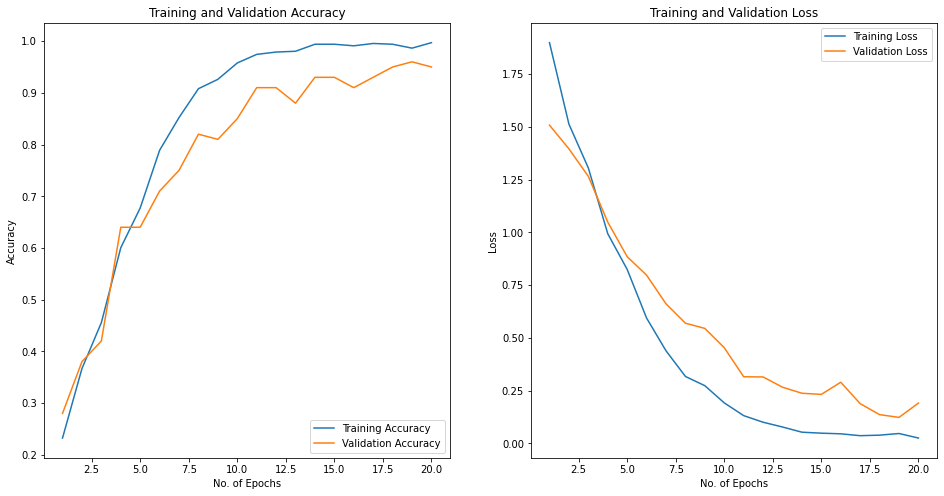

In [16]:
# Plotting results for model 14.
plot_results(history14, num_epochs)

#### Model 14 comments:
- Best metrics obtained:
    - Training Accuracy: 0.9864
    - Validation Accuracy: 0.9600
    - Training loss: 0.0471
    - Validation loss: 0.1236
    
- These are the best metrics obtained thus far and we shall cease our model tests here with a very good model based on accuracy numbers.
- The training and validation curves also increased monotonically and fairly close together during training, which is usually a good sign of a stable model.
- The wider network seems to be able to make better interpretations  of the sequences, thereby resulting in significantly better metrics compared to earlier models.
- As mentioned earlier, the pre-defined Mobilenet architecture is able to extract much more information from the input data compared to the Conv2D layers being used earlier. This may have been key to improving the model results.

**---------------------------------------------------------------------------------------------------------------------------------------------------------**

## Best Model(s)

After going through several types of architectures, we have two models which may be considered as the most suitable for our use.

- **Model 14** (Transfer Learning + GRU)
    - By sheer accuracy numbers, this is by far the best model. (Training accuracy: 0.9864, Validation accuracy: 0.96)
    - However, due to retraining of weights of the pre-trained MobilenetV2 model, the number of trainable parameters are a bit high (4,274,181)

- **Model 5** (Conv3D)
    - This is a reaonable second choice model for the task at hand. (Training accuracy: 0.9744, Validation accuracy: 0.93)
    - This model has relatively less number of trainable parameters (1,111,941). So, if memory and time are a consideration, this would pip model 14 for efficiency.
    
Hence, it essentially boils down to whether we want higher accuracy or better efficiency with slightly compromised accuracy values.

For now, we shall consider **Model 14** as our winner, and if we face any performance lags, we can revert to Model 5.

In [8]:
# Load models to check the architecture one last time
from tensorflow.keras.models import load_model

### Loading Model 14 (Best model)

In [14]:
MODEL14 = load_model('/home/dl_content/Upgrad_DL/Gesture_Recognition_Assignment/Models/model_init2021-09-2705_59_36.887904_Model14_Best/model-00019-0.04712-0.98643-0.12355-0.96000.h5')
MODEL14.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 30, 4, 4, 1280)    2257984   
_________________________________________________________________
time_distributed_1 (TimeDist (None, 30, 2, 2, 1280)    0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 30, 5120)          0         
_________________________________________________________________
gru (GRU)                    (None, 128)               2016000   
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0

### Loading Model 5 (Second Best model)

In [15]:
MODEL5 = load_model('/home/dl_content/Upgrad_DL/Gesture_Recognition_Assignment/Models/model_init2021-09-2514_26_32.975273_Model5/model-00020-0.0847-0.9774-0.3445-0.9300.h5')
MODEL5.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 30, 120, 120, 16)  1312      
_________________________________________________________________
activation (Activation)      (None, 30, 120, 120, 16)  0         
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 15, 60, 60, 16)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 15, 60, 60, 32)    13856     
_________________________________________________________________
activation_1 (Activation)    (None, 15, 60, 60, 32)    0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 7, 30, 30, 32)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 7, 30, 30, 64)     5

**End of Project**